# LCP Project: analysis of MAGIC04 dataset
### Description

The data are Monte Carlo generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). 

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

### Dataset

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 

g = gamma (signal): 12332 
h = hadron (background): 6688 

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events. 

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.


### References

[1] Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). 
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. 
Nucl.Instr.Meth. A, 516, pp. 511-528. 

[2] P. Savicky, E. Kotrc. 
Experimental Study of Leaf Confidences for Random Forest. 
Proceedings of COMPSTAT 2004, In: Computational Statistics. (Ed.: Antoch J.) - Heidelberg, Physica Verlag 2004, pp. 1767-1774. 

[3] J. Dvorak, P. Savicky. 
Softening Splits in Decision Trees Using Simulated Annealing. 
Proceedings of ICANNGA 2007, Warsaw, (Ed.: Beliczynski et. al), Part I, LNCS 4431, pp. 721-729.

[4] Aharonian, F. et al.
The Energy Spectrum of TeV Gamma-Rays from the Crab Nebula as measured by the HEGRA system of imaging air Cherenkov telescopes
Astrophys. J. 539 (2000) 317-324

[5] Aleksic, J. et al.
Measurement of the Crab Nebula spectrum over three decades in energy with the MAGIC telescopes
Journal of High Energy Astrophysics, 5–6 (2015) 30-38.

# Part 0: setup
First, we import the libraries

In [425]:
# math libraries
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy import linalg as la
from matplotlib import patches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as path_effects
import seaborn as sns
import random as rnd

# general OS libraries
from time import time
import gzip
import os
import operator
import warnings
from IPython.core.interactiveshell import InteractiveShell

# ML libraries
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.datasets import make_classification
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore') 


Then, we import the dataset and we put it into a DataFrame:

In [375]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

file_name="magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']
data   
#### save data in a DataFrame

--2025-03-12 16:10:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘magic04.data.9’

magic04.data.9          [                 <=>]   1.41M   370KB/s    in 4.6s    

2025-03-12 16:10:50 (313 KB/s) - ‘magic04.data.9’ saved [1477391]



,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,category
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
...,...,...,...,...,...,...,...,...,...,...,...
19014,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19015,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19016,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19017,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In this cell we print the number of data of each label and the relative frequence

In [376]:
print('All data points:',len(data['fAlpha']),'points for',len(data.columns[:]),'columns')
print('labels and their relative frequencies:')

ngamma = len(data[data['category'] == 'g'] )
nback = len(data[data['category'] == 'h'] )
print(f'signal: \t{ngamma} \t {round(ngamma/len(data['fAlpha'])*100,2)}%')
print(f'background:\t {nback} \t {round(nback/len(data['fAlpha'])*100,2)}%')



All data points: 19019 points for 11 columns
labels and their relative frequencies:
signal: 	12331 	 64.84%
background:	 6688 	 35.16%


We observe that about 2/3 of the dataset is labelled as signal, while only 1/3 as background. The dataset is indeed built underestimating the amount of background signal acquired.

Here we write some useful functions for the code

## ML functions

In [377]:
# this function divides the dataset in input in parts_to_be_split parts. One of them is returned as test_set
# the other ones are the training_set. Indexes of the chosen data can be accessed (test_indexes, train_indexes)
# (for example in a K-fold)

def split_train_test_set(data,parts_to_be_split):
    indexes = np.arange(0,data.shape[0],1)
    rnd.shuffle(indexes)
    len_test_set = int(len(indexes) / parts_to_be_split)

    test_indexes = indexes[:len_test_set]
    train_indexes = indexes[len_test_set:]

    train_set = data.iloc[train_indexes]
    test_set = data.iloc[test_indexes]
    
    return train_set, test_set

# this function takes col category and returns as Y (target), the other columns are X (labels)
def split_X_Y(data):
    Y = data['category']
    X = data.drop('category',axis=1)

    return X,Y

# this function takes the point that has the lowest distance from FPR=0 and TPR=1 and computes Q for that point values
def get_best_Q(fpr,tpr):
    distances = np.zeros(len(fpr))
    
    for i in range(len(fpr)):
        distances[i] = np.sqrt(fpr[i]**2+(1-tpr[i])**2)
        
    min_dist_idx = np.argmin(distances)
    
    best_Q = tpr[min_dist_idx] / np.sqrt(fpr[min_dist_idx])
    return best_Q

## Other functions
### Cutting functions

In [378]:
# this function finds cut value starting from possible max
def find_max_cut_value(X_train,Y_train,sel_label,min_hadrons):
    new_X = X_train[X_train.columns[sel_label]]
    new_data = np.vstack((new_X,Y_train))
    new_data_sorted = new_data[:, new_data[0].argsort()]
    
    #new_data_sorted_reversed = new_data_sorted[:, ::-1] #reverse!! STARTING FROM MAXX
    
    # setup vars, cut value is  set to max of the label, so that in worst scenario all points are true hadrons
    true_hadrons = 0
    max_cut_value = new_data_sorted[0,0]
    
    for i in range(new_data_sorted.shape[1]):
        if new_data_sorted[1,i] == -1:
            true_hadrons += 1
        if true_hadrons == min_hadrons:
            max_cut_value = new_data_sorted[0,i]
            
    return max_cut_value

# this functions returns the number of true positive and false positive points on test set
def find_tp_fp(X_test,Y_test,sel_label,cut_value):
    new_X = X_test[X_test.columns[sel_label]]
    new_data = np.vstack((new_X,Y_test))
    new_data_sorted = new_data[:, new_data[0].argsort()]
    new_data_sorted_reversed = new_data_sorted[:, ::-1] #reverse!! STARTING FROM MAXX
    fp = 0
    tp = 0
    
    for i in range(new_data_sorted_reversed.shape[1]):
        if new_data_sorted_reversed[0,i] < cut_value:
            if new_data_sorted_reversed[1,i] == 1:
                tp += 1
            if new_data_sorted_reversed[1,i] == -1:
                fp += 1
                
    return tp, fp # true positive, false positive

# Part 1: study of the dataset


### Part 1.1 Camera plane reconstruction
The following code recontrsucts the traces detected by the telescope camera. In orange and red are represented the detected gammas, while in blue are represented the detected hadrons

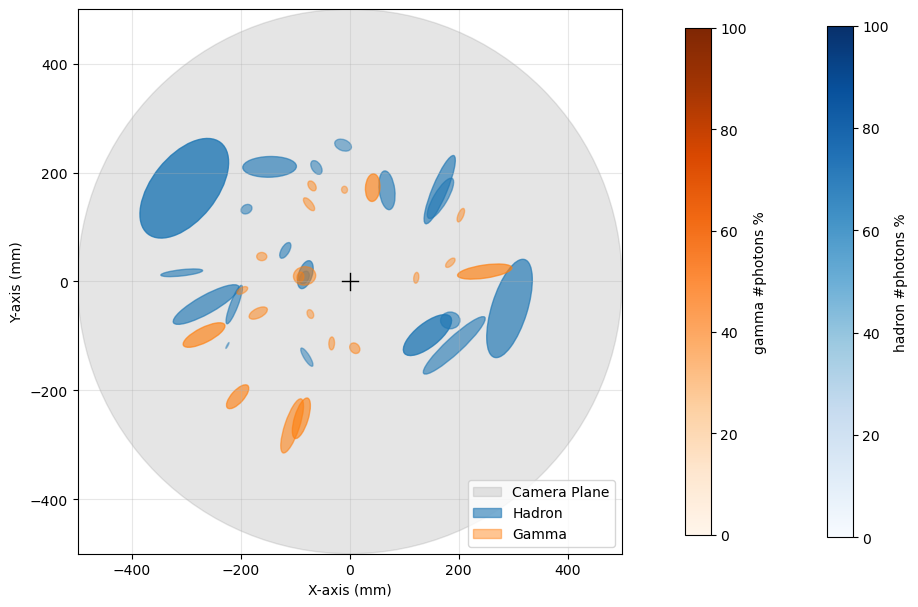

In [379]:
datasig = data[data['category'] == 'g'] 
databkg = data[data['category'] == 'h'] 
# visualize data
n_ellipses = 20

# ellipse parameters
random_angle_sig = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
sig_idx = np.random.randint(0,10000, size=n_ellipses)
sig_ellipse_params = [ 
    {
        'center': (datasig['fDist'][idx] * np.cos(random_angle_sig[i]), datasig['fDist'][idx] * np.sin(random_angle_sig[i])),  
        'width': datasig['fWidth'][idx], 
        'height': datasig['fLength'][idx], 
        'angle': datasig['fAlpha'][idx],
        'alpha': datasig['fSize'][idx]/data['fSize'].max()
        } 
    for i, idx in enumerate(sig_idx)
    ]

random_angle_bkg = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
bkg_idx = np.random.randint(13000,19000, size=n_ellipses)
bkg_ellipse_params = [ 
    {
        'center': (databkg['fDist'][idx] * np.cos(random_angle_bkg[i]), databkg['fDist'][idx] * np.sin(random_angle_bkg[i])),
        'width': databkg['fWidth'][idx], 
        'height': databkg['fLength'][idx], 
        'angle': databkg['fAlpha'][idx],
        'alpha': databkg['fSize'][idx]/data['fSize'].max()
        } 
    for i, idx in enumerate(bkg_idx)
    ]

fig, ax = plt.subplots(figsize=(10,12))

ax.grid(alpha=0.3)

# plot ellipses
radius = 500
camera_circle = patches.Circle((0,0), radius, alpha=0.2, color='grey')
ax.add_patch(camera_circle)

bkg_ellipses = []
sig_ellipses = []

for params in bkg_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'], 
        width=params['width'], 
        height=params['height'], 
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi), 
        fill=True, 
        alpha=params['alpha'], 
        color='C0'
        )
    ax.add_patch(ellipse)
    bkg_ellipses.append(ellipse)

for params in sig_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'], 
        width=params['width'], 
        height=params['height'], 
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi),
        alpha=params['alpha'], 
        color='C1'
        )
    ax.add_patch(ellipse)
    sig_ellipses.append(ellipse)

ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_aspect('equal')

legend_labels = ['Camera Plane', 'Hadron', 'Gamma']
legend_handles = [camera_circle, bkg_ellipses[0], sig_ellipses[0]]
ax.legend(legend_handles, legend_labels, loc='lower right')

center_cross_size = 15
ax.plot([0, 0], [-center_cross_size, center_cross_size], color='black', linewidth=1)
ax.plot([-center_cross_size, center_cross_size], [0, 0], color='black', linewidth=1)

# color scale indicating alpha for background ellipses
bkg_alphas = [params['alpha'] for params in bkg_ellipse_params]
bkg_norm = Normalize(vmin=0, vmax=100)
bkg_scalar_map = ScalarMappable(norm=bkg_norm, cmap='Blues')
bkg_scalar_map.set_array(bkg_alphas)
bkg_colorbar = plt.colorbar(bkg_scalar_map, ax=ax, fraction=0.033, pad = 0.15)
bkg_colorbar.set_label('hadron #photons %')

# color scale indicating alpha for signal ellipses
sig_alphas = [params['alpha'] for params in sig_ellipse_params]
sig_norm = Normalize(vmin=0, vmax=100)
sig_scalar_map = ScalarMappable(norm=sig_norm, cmap='Oranges')
sig_scalar_map.set_array(sig_alphas)
sig_colorbar = plt.colorbar(sig_scalar_map, ax=ax, fraction=0.04, pad = 0.1)
sig_colorbar.set_label('gamma #photons %')

ax.set_xlabel('X-axis (mm)')
ax.set_ylabel('Y-axis (mm)')

plt.show();

This recontstruction resembles the acquisition of some signals. It is observed that the orange ellypses, representing data labeled as "gamma", are mostly radially oriented, while the orientation of the "hadrons" ellypses seems random. We can conclude that the photon shower axis is parallel to the telescope's optical axis. The colorbars represent the alpha parameter of the represented particles.

### Part 1.2 plot of the features 
the following code plots histograms for each feature, in red there are gammas (signal), in blue hadrons (background). The code saves the histograms in a directory named 'part_1_plots'

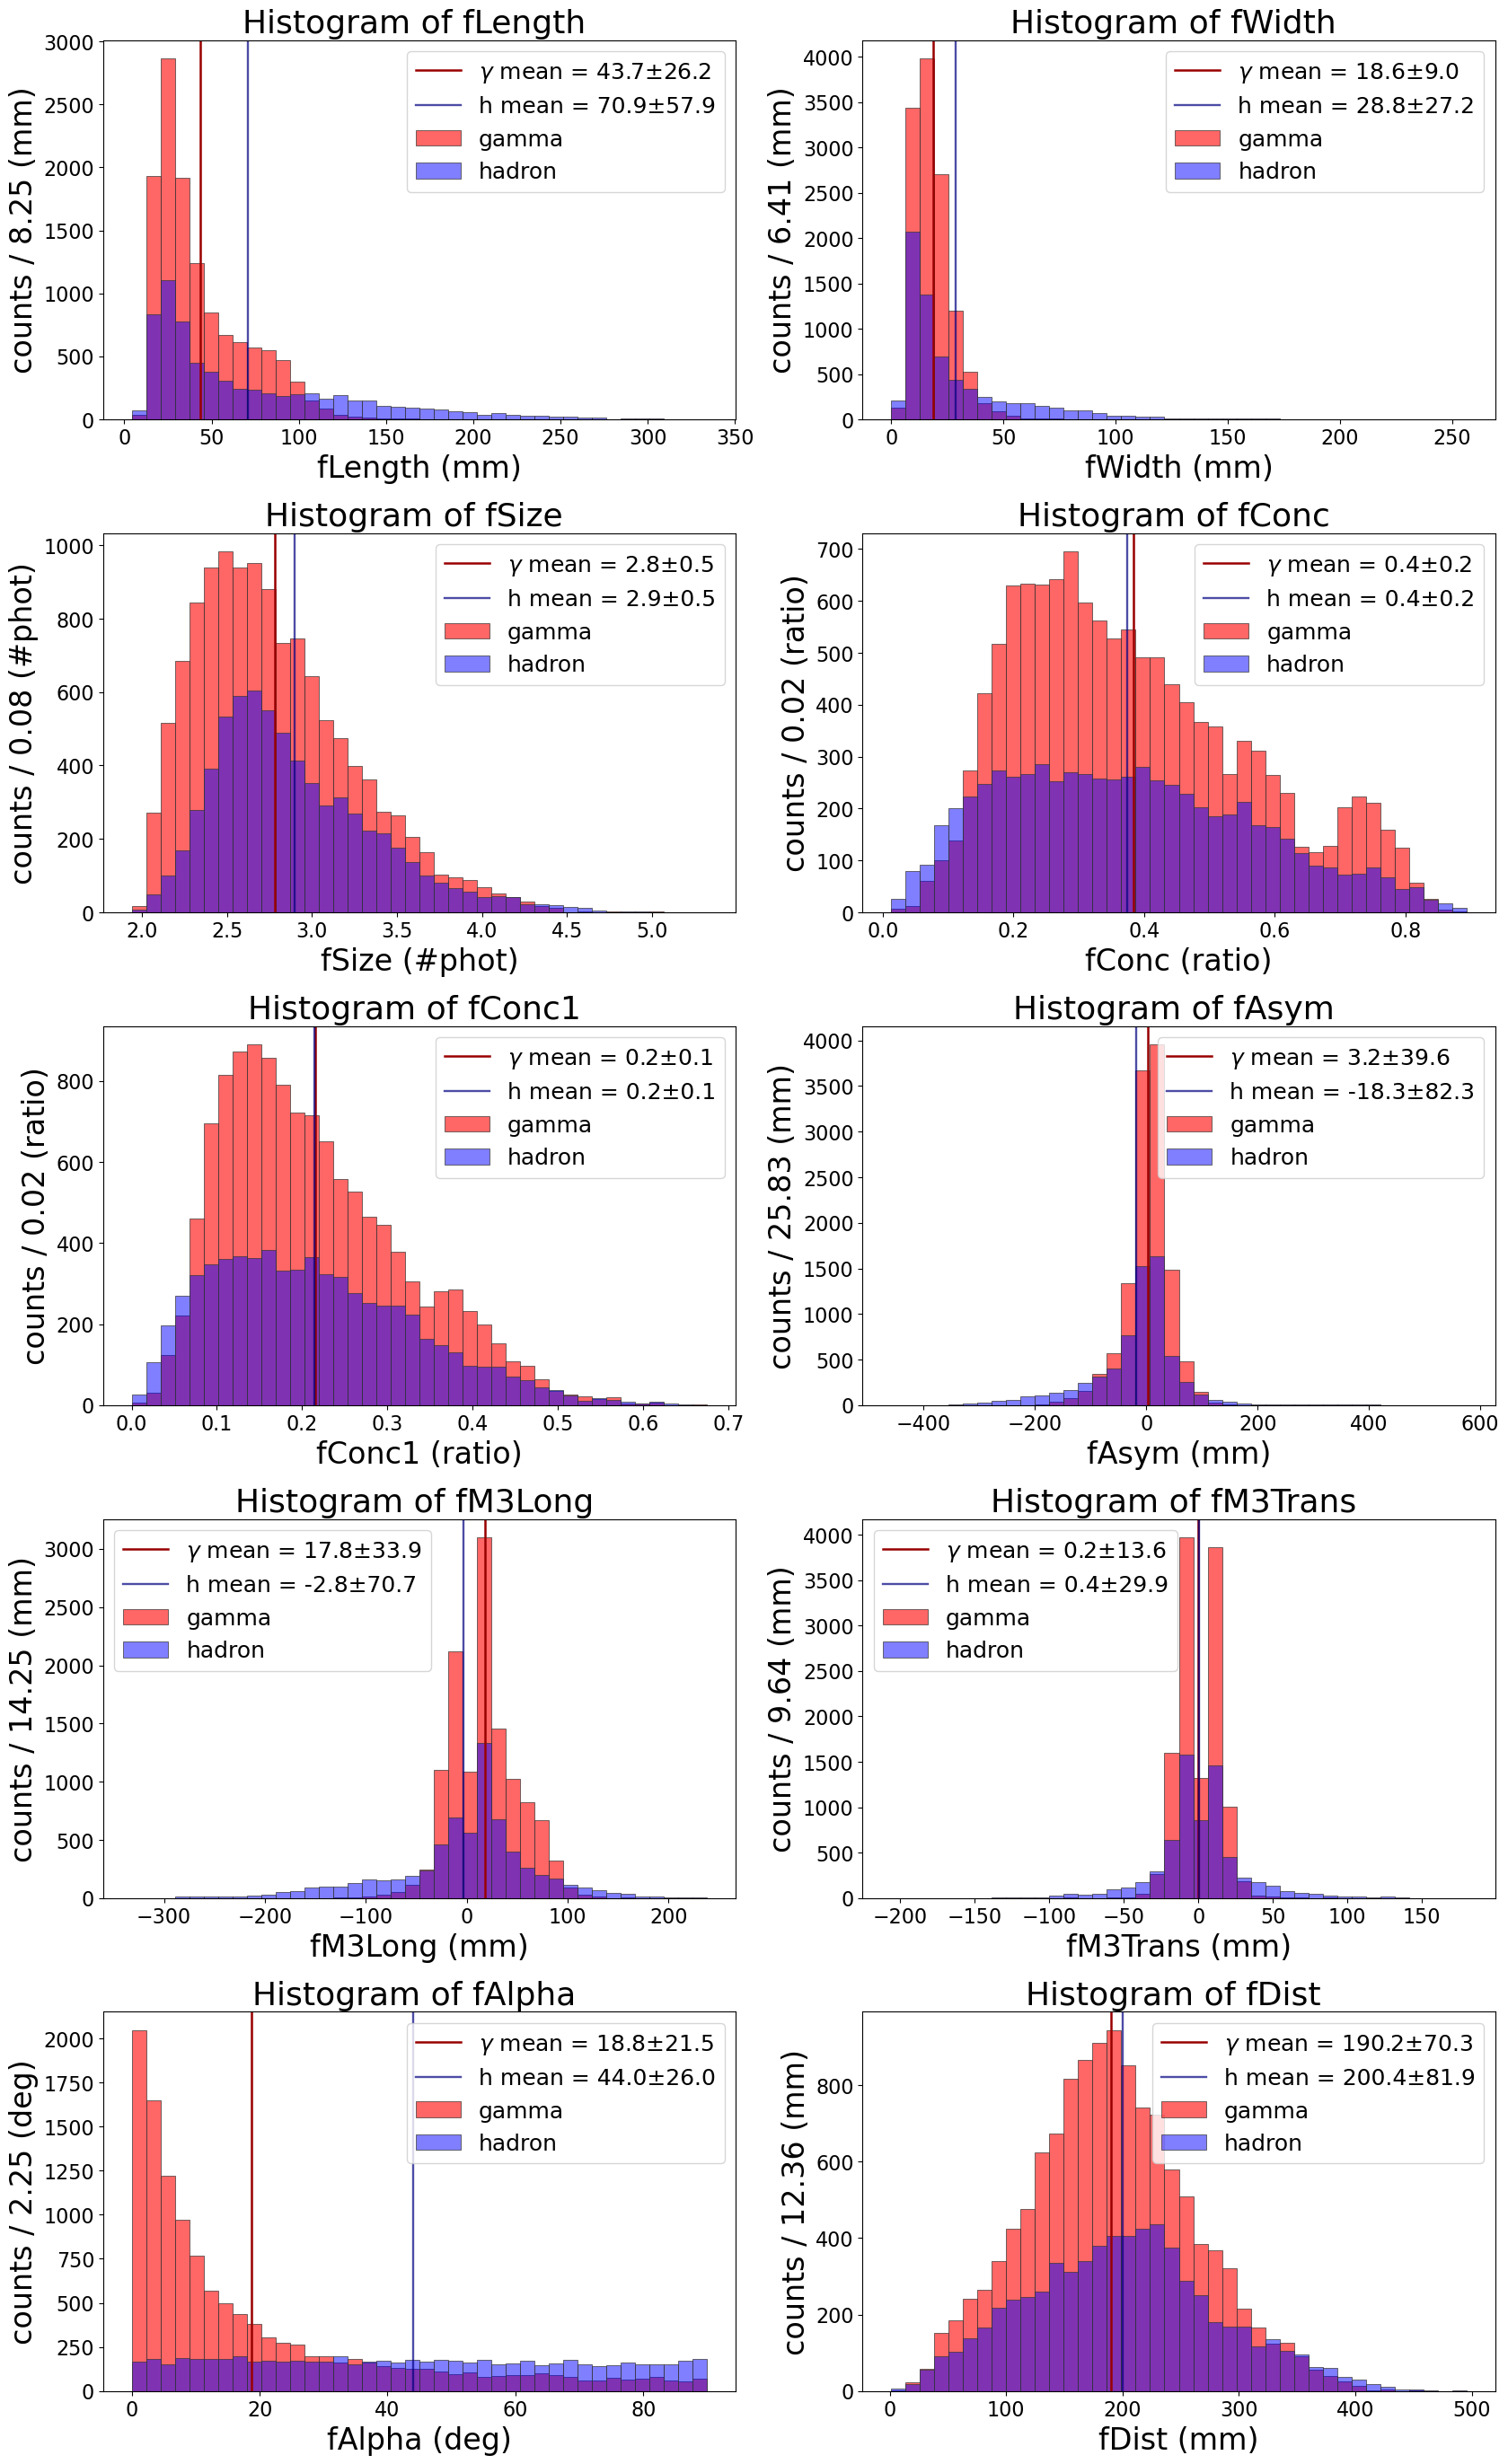

In [383]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 34))
fig.subplots_adjust(hspace=0.3)

udm = ['fLength ', 'fWidth ', 'fSize ', 'fConc ', 'fConc1 ', 
       'fAsym ', 'fM3Long ', 'fM3Trans ', 'fAlpha ', 'fDist ']

units = ['(mm)','(mm)','(#phot)','(ratio)','(ratio)','(mm)','(mm)','(mm)','(deg)','(mm)']
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 
            'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
bins = 40

avgs_g = []
avgs_h = []
stds_g = []
stds_h = []
lambdas = []

for i in range(5):
    for j in range(2):
            
        idx = 2 * i + j  # Update index to match new layout
        if (udm[idx] == 'fWidth (mm)'):
            bins = 50
        
        min_val = min(datasig[features[idx]].min(), databkg[features[idx]].min())
        max_val = max(datasig[features[idx]].max(), databkg[features[idx]].max())
        common_bins = np.linspace(min_val, max_val, bins + 1)
        
        #ax[i, j].grid()
        sns.histplot(datasig[features[idx]], bins = common_bins, kde=False, color='red', alpha=0.6, label='gamma', ax=ax[i, j], edgecolor='#383734', linewidth=0.5)
        sns.histplot(databkg[features[idx]], bins = common_bins, kde=False, color='blue', alpha=0.5, label='hadron', ax=ax[i, j], edgecolor='#383734', linewidth=0.5)
        mu_g = np.mean(datasig[features[idx]])
        mu_h = np.mean(databkg[features[idx]])
        std_g = np.std(datasig[features[idx]])
        std_h = np.std(databkg[features[idx]])
        avgs_g.append(mu_g)
        avgs_h.append(mu_h)
        stds_g.append(std_g)
        stds_h.append(std_h)
        lambdas.append(abs(mu_g-mu_h)/(std_g**2 + std_h**2)**(1/2))
        
        ax[i, j].axvline(mu_g,c='#990000', label= f'$\gamma$ mean = {round(mu_g,1)}±{round(std_g,1)}', lw=1.8)
        ax[i, j].axvline(mu_h,c='navy',label= f'h mean = {round(mu_h,1)}±{round(std_h,1)}', lw=1.7,alpha=0.7)
        ax[i, j].set_xlabel(f'{udm[idx]}{units[idx]}', fontsize=24)
        ax[i, j].set_ylabel(f'counts / {round(common_bins[1]-common_bins[0],2)} {units[idx]}', fontsize=24)
        ax[i, j].tick_params(axis='both', which='major', labelsize=16)
        ax[i, j].legend(loc='best', fontsize=18)
        ax[i, j].set_title(f'Histogram of {udm[idx]}', fontsize=26)
        
        '''if (udm[idx] == 'fLength (mm)'):
            ax[i, j].set_xlim(-5,260)
        if (udm[idx] == 'fWidth (mm)'):
            ax[i, j].set_xlim(-10,120)'''
            
        
        #ax[i, j].text(x=3,y=160,s=fr"$\mu_{{g}}$={mu_g:.2f} $\pm$ {l_std_g_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
        #ax[i, j].text(x=3,y=130,s=fr"$\mu_{{h}}$={mu_h:.2f} $\pm$ {l_std_h_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

    
#plt.tight_layout()
plt.show();

In [384]:
print(f'feature \t gamma \t \thadrons \tcompatibility (lambda)')
for i in range(len(avgs_g)):
    print(f'{udm[i]}{units[i]}\t',f'{round(avgs_g[i],1)} \u00B1 {round(stds_g[i],1)}', f'\t{round(avgs_h[i],1)} \u00B1 {round(stds_h[i],1)}', f'\t\033[32m{round(lambdas[i],2)}\033[0m')

feature 	 gamma 	 	hadrons 	compatibility (lambda)
fLength (mm)	 43.7 ± 26.2 	70.9 ± 57.9 	0.43
fWidth (mm)	 18.6 ± 9.0 	28.8 ± 27.2 	0.36
fSize (#phot)	 2.8 ± 0.5 	2.9 ± 0.5 	0.17
fConc (ratio)	 0.4 ± 0.2 	0.4 ± 0.2 	0.04
fConc1 (ratio)	 0.2 ± 0.1 	0.2 ± 0.1 	0.01
fAsym (mm)	 3.2 ± 39.6 	-18.3 ± 82.3 	0.24
fM3Long (mm)	 17.8 ± 33.9 	-2.8 ± 70.7 	0.26
fM3Trans (mm)	 0.2 ± 13.6 	0.4 ± 29.9 	0.01
fAlpha (deg)	 18.8 ± 21.5 	44.0 ± 26.0 	0.75
fDist (mm)	 190.2 ± 70.3 	200.4 ± 81.9 	0.09


We observe that the mean values of all features for hadrons and gammas are compatible. Also they distribute in similar shapes, except for `fAlpha`. Therefore is not possible to distinguish signal from background from the distributions. 

# Part 2: studying the correlations
in this section each feature will be confronted with all the others. Results will be put in a 2D correlation matrix (n_features x n_features) to visualize the results

First we rescale all features to have average = 0 and dev_std = 1 (Alpha is rescaled in this part, but will be restored for the later sections).

In [385]:
X = data[['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist']]
Y = data['category']
print(X['fAlpha'])


0         6.3609
1        76.9600
2        10.4490
3         4.6480
4         3.6130
          ...   
19014     2.4229
19015    86.7975
19016    30.2987
19017    84.6874
19018    52.7310
Name: fAlpha, Length: 19019, dtype: float64


In [386]:
X_rescaled = X.copy()
original_alpha = X['fAlpha'].copy()

for i in range(X.shape[1]):
    h = X[str(X.columns[i])]
    avg = np.average(h)
    std = np.std(h)
    h = h - avg
    h = h / std
    X_rescaled[str(X_rescaled.columns[i])] = h
    
print('avg length:',round(np.average(X_rescaled['fLength']),15))
print('std length:',round(np.std(X_rescaled['fLength']),15))

avg length: 0.0
std length: 0.999999999999997


The following cell computes the correlation matrix taking apart gammas from hadrons

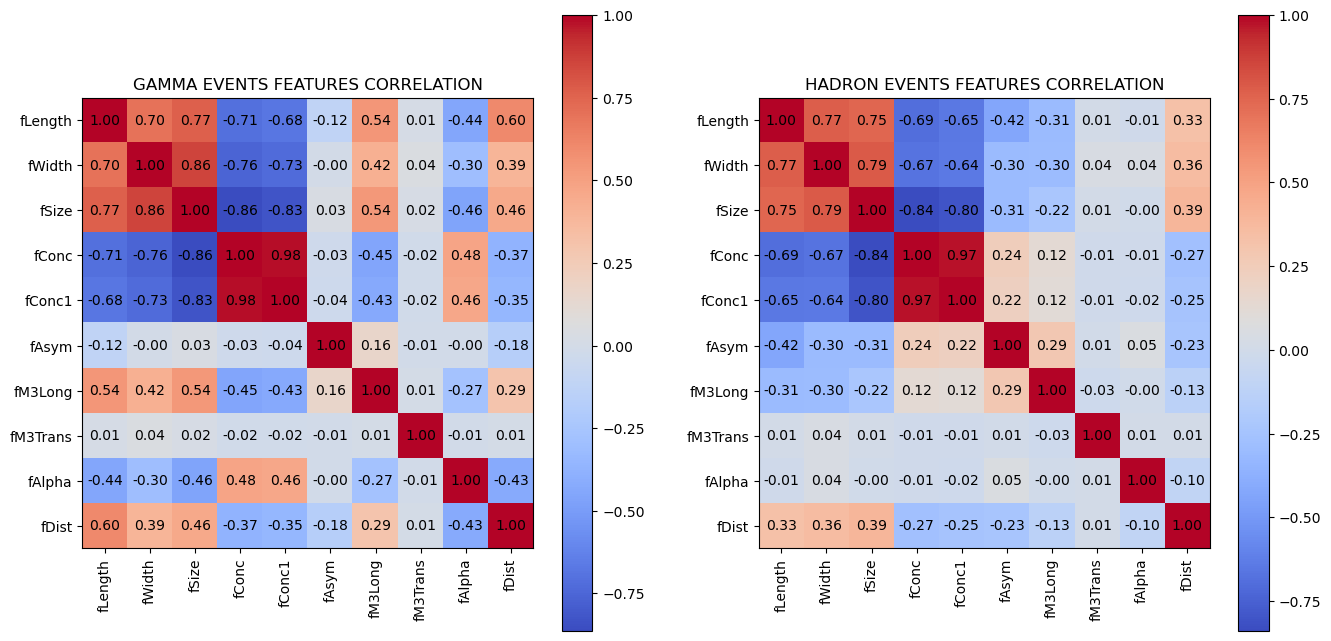

In [387]:
Xg_rescaled = X_rescaled[Y == 'g']
Xh_rescaled = X_rescaled[Y == 'h']
features = features[:10]


cov = np.zeros((Xg_rescaled.shape[1],Xg_rescaled.shape[1]))
for i in range(Xg_rescaled.shape[1]):
    h = Xg_rescaled[str(Xg_rescaled.columns[i])]
    for j in range(Xg_rescaled.shape[1]):
        v = Xg_rescaled[str(Xg_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])
        
std_devs = np.std(Xg_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs) # the data for gamma events are not normalized with respsect to themselv   



ticks = np.arange(0,10,1)
x_ticks = np.arange(cov.shape[1]) + 0.5
y_ticks = np.arange(cov.shape[0]) + 0.5

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
cax = ax[0].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[0].set_xticks(ticks, minor=False)
ax[0].set_yticks(ticks, minor=False)
ax[0].set_xticklabels(features,rotation=90)
ax[0].set_yticklabels(features)
ax[0].grid(which='minor', color='black', linewidth=2)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[0].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

#ax[0].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
#ax[0].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[0].set_title('GAMMA EVENTS FEATURES CORRELATION')

cov = np.zeros((Xh_rescaled.shape[1],Xh_rescaled.shape[1]))
for i in range(Xh_rescaled.shape[1]):
    h = Xh_rescaled[str(Xh_rescaled.columns[i])]
    for j in range(Xh_rescaled.shape[1]):
        v = Xh_rescaled[str(Xh_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])
        
std_devs = np.std(Xh_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs)

cax = ax[1].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[1].set_xticks(ticks, minor=False)
ax[1].set_yticks(ticks, minor=False)
ax[1].set_xticklabels(features, rotation=90)
ax[1].set_yticklabels(features)
ax[1].grid(which='minor', color='black', linewidth=1)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[1].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

#ax[1].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[1].set_title('HADRON EVENTS FEATURES CORRELATION')

plt.show();

We observe that the most correlated features are the first 5. The correlation between the first 3 is positive, while correlation between `fConc1` and `fConc2` is negative, and very close to 1. This is in agreement for both signal and background events. Differences can be seen while observing other parameters:
- `fAlpha`: this parameter is slightly correlated to the others for gamma events, but sees almost no correlation for background ones
- `fAsym`: this parameter sees the opposite than `fAlpha`
- `fM3Long`: the correlation of this parameter is present for both signal and background events, but has its sign swapped

## Part 2.1: Correlation between features and label
In this part we check the correlation between features and label Y. This is done to find the most informative parameters for the classification.

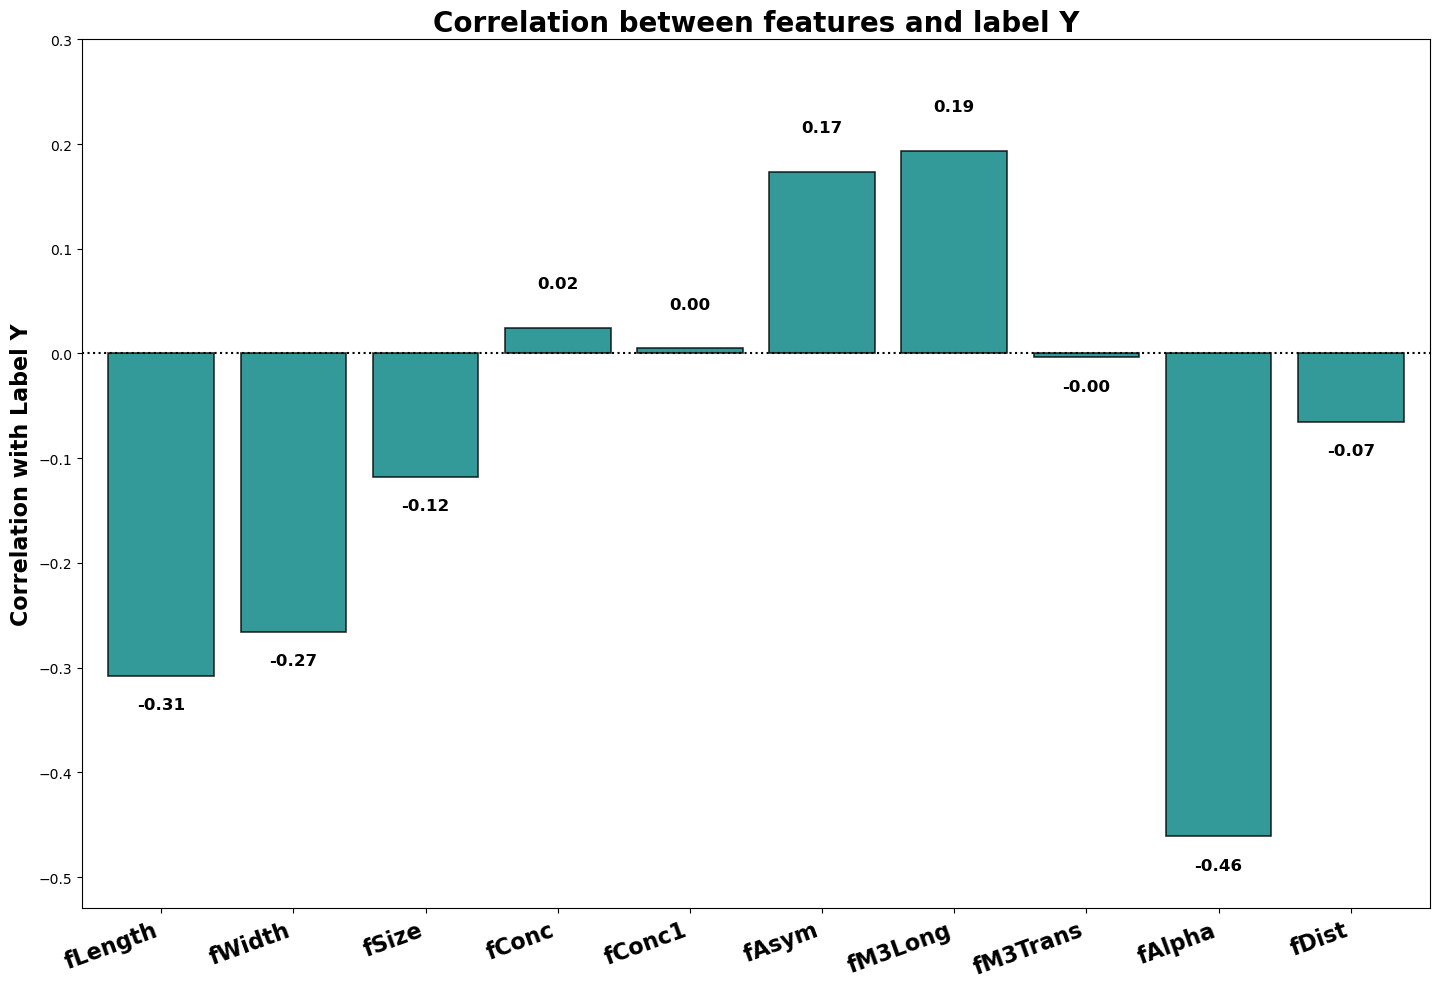

In [388]:
# Calculate the correlation between each feature and the label Y

Y_array = np.where(Y == 'g', 1, -1)
Y_array = np.array(Y_array) 
feature_names = data.columns[:10]

correlations = np.zeros(X_rescaled.shape[1])  
for i in range(X_rescaled.shape[1]):
    feature = X_rescaled.iloc[:, i]  
    correlations[i] = np.corrcoef(feature, Y_array)[0, 1]

# create a bar plot to display the correlations
fig, ax = plt.subplots(figsize=(14.5, 10))

bars = ax.bar(feature_names, correlations, color='teal', edgecolor='black', linewidth=1.2,alpha=0.8)

# add correlation values on top of each bar
for i, corr in enumerate(correlations):
    ax.text(i, corr + 0.035 if corr>=0 else corr-0.035, f'{corr:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_ylabel('Correlation with Label Y', fontsize=16, fontweight='bold')
ax.set_ylim(-0.53,0.3)
ax.set_title('Correlation between features and label Y', fontsize=20, fontweight='bold')
ax.set_xticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, fontsize=16, fontweight='bold', rotation=20, ha='right')

x_line = np.linspace(-0.6,len(feature_names),100)
y_line = np.linspace(0,0,100)
ax.plot(x_line, y_line, linestyle='dotted', color='black') 
ax.set_xlim(-0.6,9.6)

plt.tight_layout()
plt.show()

The features most strongly correlated with the label Y, and thus most informative for distinguishing between gamma and hadron events, are `fAlpha`
, `flength` and `fWidth` This is coherent with our observations from the feature histograms, where these features exhibit more distinct distributions between the two classes.

# Part 3: comparison of the features rescaled

In this section we analyze the distributions of the `fWidth` and `fLength` parameters. First of all we have computed the mean and standard deviation for both samples and we rescaled them. Then the distribution of both "`fWidth` and `fLength` was plotted dividing the gamma from the hadron events.

We then used the `fSize` parameter to apply a cut to both the signals (gamma) and background (hadron) events and considered only the tails of their distribution. Since `fSize` is proportional to the number of photons, for both the width and lenght distribution we defined as "High energy events" the data points higher than 𝜇+𝜎
(right-side tail) and as "Low energy events" the data points lower than 𝜇−𝜎. Considering 𝜇 and 𝜎 rispectively as the mean and standard deviation of the rescaled width and lenght distributions.

From this comparison we can clearly see that in the high energy tail the signal is more clustered and separated from the background, despite having a smaller number of gamma events in this energy region. Meanwhile in the low energy tail signal and background events are more evenly distributed.

Therefore,considering only the high energy region could give us an edge while classifying the events into signal and background.

In [389]:
## find mean and std

mu_l=data['fLength'].mean()
std_l=data['fLength'].std()
mu_w=data['fWidth'].mean()
std_w=data['fWidth'].std()
print('Length attribute:   mean = ', round(mu_l,3), '    std = ', round(std_l,3))
print('Width attribute:    mean = ', round(mu_w,3), '   std = ', round(std_w,3))
data['scaled_fLength']= (data['fLength']-mu_l)/std_l   ##add a scaled comlumn to the DataFrame
data['scaled_fWidth']= (data['fWidth']-mu_w)/std_w  

Length attribute:   mean =  53.251     std =  42.366
Width attribute:    mean =  22.181    std =  18.346


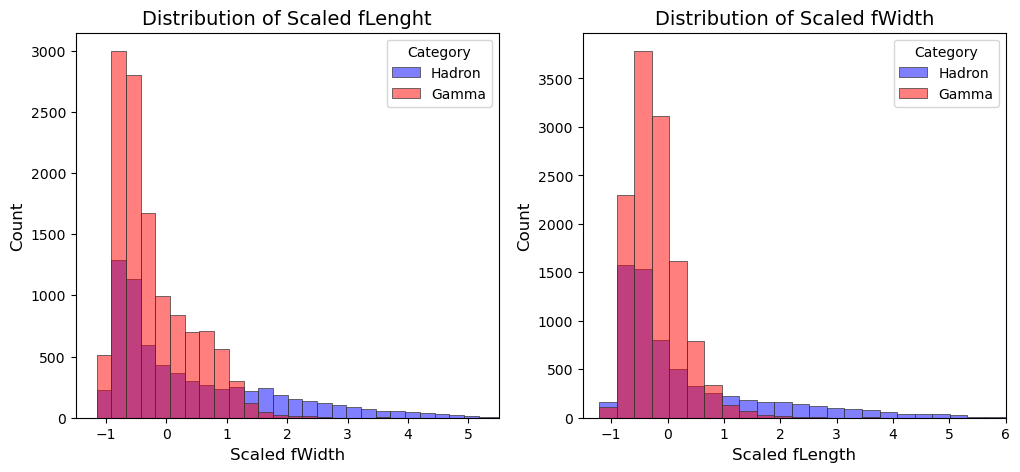

In [390]:
###plots of the scaled distribution before cutting 

bins = 32
common_bins = np.linspace(min(data['scaled_fLength']), max(data['scaled_fLength']), bins + 1)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(data,x=data['scaled_fLength'],hue='category',bins = common_bins, kde=False, ax=ax[0], palette=['red','blue'], edgecolor='#383734', linewidth=0.5)
ax[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax[0].set_xlabel("Scaled fWidth", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].set_xlim(-1.5, 5.5)  
legend = ax[0].get_legend()

ax[0].legend(['Hadron', 'Gamma'], title='Category')

bins = 45
common_bins = np.linspace(min(data['scaled_fWidth']), max(data['scaled_fWidth']), bins + 1)
sns.histplot(data,x=data['scaled_fWidth'],hue='category',bins = common_bins, kde=False, ax=ax[1], palette=['red','blue'], edgecolor='#383734', linewidth=0.5)
ax[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax[1].set_xlabel("Scaled fLength", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].set_xticks(range(-1,9))
ax[1].set_xlim(-1.5, 6)  
legend = ax[1].get_legend()
ax[1].legend(['Hadron', 'Gamma'], title='Category');


In [391]:
median_fSize = data['fSize'].median()
min_fSize = data['fSize'].min()
max_fSize = data['fSize'].max()
mean_fSize = data['fSize'].mean()
std_fSize = data['fSize'].std()
print("Statistichal informations of fSize: \nmedian=",median_fSize, '\nmin=', min_fSize, '\nmax=', max_fSize, '\nmean=', round(mean_fSize,3), '\nstd=', round(std_fSize,3))


Statistichal informations of fSize: 
median= 2.7396 
min= 1.9413 
max= 5.3233 
mean= 2.825 
std= 0.473


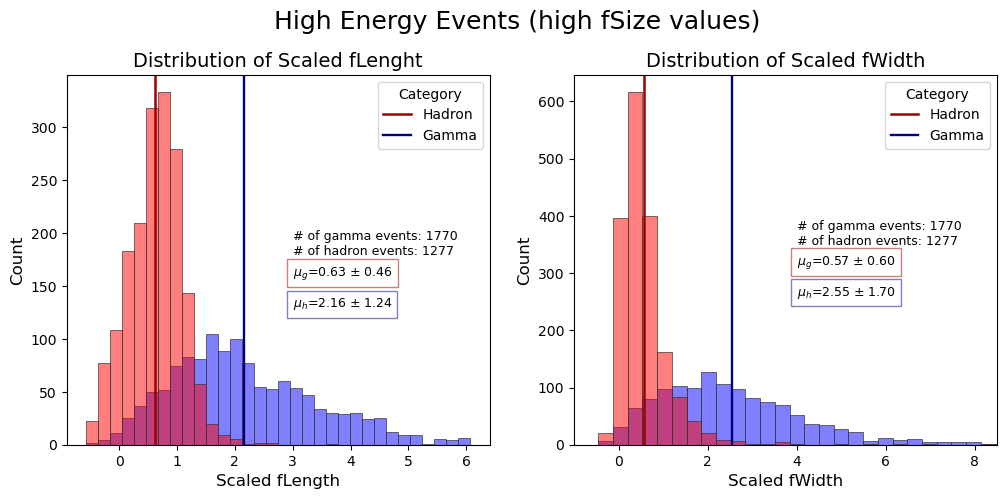

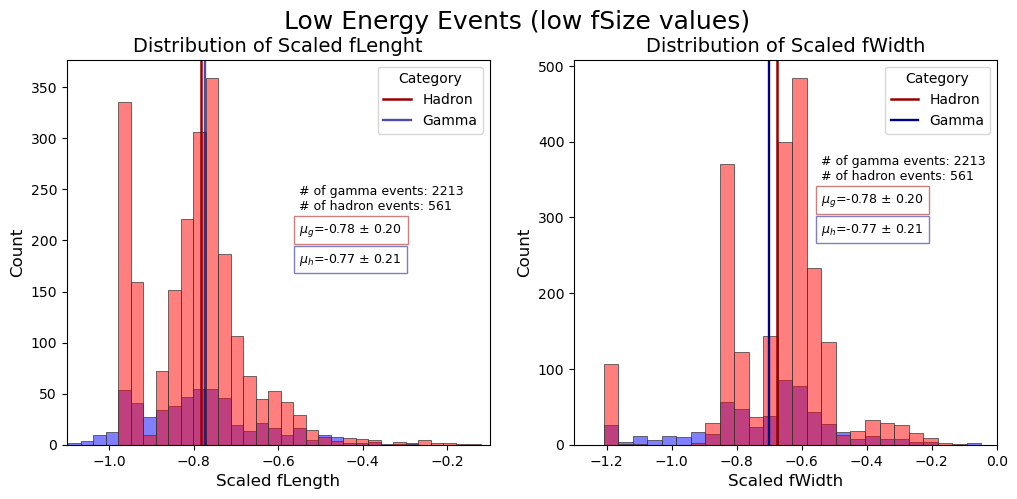

In [392]:
#### plots at high energy

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('High Energy Events (high fSize values)', fontsize=18)

fig.subplots_adjust(top=0.85)  

##useful variables
ng_high=len(data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize])
nh_high=len(data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize])
l_mu_g_high=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].mean()
l_mu_h_high=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].mean()
l_std_g_high=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].std()
l_std_h_high=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].std()
w_mu_g_high=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].mean()
w_mu_h_high=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].mean()
w_std_g_high=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].std()
w_std_h_high=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].std()

##plot length - high energy
sns.histplot(data,x=data['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize],hue='category',hue_order=['g', 'h'], kde=False, color='blue', ax=ax[0], palette=['red','blue'], edgecolor='#383734', linewidth=0.5,bins=32)
ax[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax[0].set_xlabel("Scaled fLength", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].axvline(l_mu_g_high,c='#990000', label= r'$\mu_{g}$', lw=1.8)
ax[0].axvline(l_mu_h_high,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[0].get_legend()
ax[0].legend(['Hadron', 'Gamma'], title='Category')
ax[0].text(x=3,y=180,s=f"# of gamma events: {ng_high} \n# of hadron events: {nh_high}", fontsize=9, color='black')
ax[0].text(x=3,y=160,s=fr"$\mu_{{g}}$={l_mu_g_high:.2f} $\pm$ {l_std_g_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax[0].text(x=3,y=130,s=fr"$\mu_{{h}}$={l_mu_h_high:.2f} $\pm$ {l_std_h_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

#plot width - high energy
sns.histplot(data,x=data['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize],hue='category', kde=False, color='blue', ax=ax[1], palette=['red','blue'], edgecolor='#383734', linewidth=0.5,bins=40)
ax[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax[1].set_xlabel("Scaled fWidth", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].set_xlim(-1,8.5)
ax[1].axvline(w_mu_g_high,c='#990000', lw = 1.8) #label= r'$\mu_{g}$', lw=1.8)
ax[1].axvline(w_mu_h_high,c='navy', lw = 1.7) #label=r'$\mu_{h}$', lw=1.7)
legend = ax[1].get_legend()
ax[1].legend(['Hadron', 'Gamma'], title='Category')
ax[1].text(x=4,y=350,s=f"# of gamma events: {ng_high} \n# of hadron events: {nh_high}", fontsize=9, color='black')
ax[1].text(x=4,y=315,s=fr"$\mu_{{g}}$={w_mu_g_high:.2f} $\pm$ {w_std_g_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax[1].text(x=4,y=260,s=fr"$\mu_{{h}}$={w_mu_h_high:.2f} $\pm$ {w_std_h_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

#### plots at low energy

fig1, ax1 = plt.subplots(1, 2, figsize=(12,5))
fig1.suptitle('Low Energy Events (low fSize values)', fontsize=18)
fig.subplots_adjust(top=0.85)  
###useful variables
ng_low=len(data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize])
nh_low=len(data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize])
l_mu_g_low=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].mean()
l_mu_h_low=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].mean()
l_std_g_low=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].std()
l_std_h_low=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].std()
w_mu_g_low=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].mean()
w_mu_h_low=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].mean()
w_std_g_low=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].std()
w_std_h_low=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].std()

## plot length - low energy
sns.histplot(data,x=data['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize],hue='category', kde=False, color='blue', ax=ax1[0], palette=['red','blue'],edgecolor='#383734', linewidth=0.5, bins=180)
ax1[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax1[0].set_xlabel("Scaled fLength", fontsize=12)
ax1[0].set_ylabel("Count", fontsize=12)
ax1[0].axvline(l_mu_g_low,c='#990000', label= r'$\mu_{g}$', lw=1.8)
ax1[0].axvline(l_mu_h_low,c='navy',label=r'$\mu_{h}$', lw=1.7,alpha=0.7)
legend = ax[0].get_legend()
ax1[0].legend(['Hadron', 'Gamma'], title='Category')
ax1[0].set_xlim(-1.1,-0.1)
ax1[0].text(x=-0.55,y=230,s=f"# of gamma events: {ng_low} \n# of hadron events: {nh_low} ", fontsize=9, color='black')
ax1[0].text(x=-0.55,y=208,s=fr"$\mu_{{g}}$={l_mu_g_low:.2f} $\pm$ {l_std_g_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax1[0].text(x=-0.55,y=178,s=fr"$\mu_{{h}}$={l_mu_h_low:.2f} $\pm$ {l_std_h_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

## plot width - low energy
sns.histplot(data,x=data['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize],hue='category', kde=False, color='blue', ax=ax1[1], palette=['red','blue'], edgecolor='#383734', linewidth=0.5,bins=30)
ax1[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax1[1].set_xlabel("Scaled fWidth", fontsize=12)
ax1[1].set_ylabel("Count", fontsize=12)
ax1[1].set_xlim(-1.3,0.0)
ax1[1].axvline(w_mu_g_low,c='#990000', label= r'$\mu_{g}$', lw=1.8)
ax1[1].axvline(w_mu_h_low,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[1].get_legend()
ax1[1].legend(['Hadron', 'Gamma'], title='Category')
ax1[1].text(x=-0.54,y=350,s=f"# of gamma events: {ng_low} \n# of hadron events: {nh_low}", fontsize=9, color='black')
ax1[1].text(x=-0.54,y=320,s=fr"$\mu_{{g}}$={l_mu_g_low:.2f} $\pm$ {l_std_g_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax1[1].text(x=-0.54,y=280,s=fr"$\mu_{{h}}$={l_mu_h_low:.2f} $\pm$ {l_std_h_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))


plt.show();

# Part 4: PCA
In this part we will perform Principal Component Analysis (PCA). PCA is a statistical tecnique used for reducing the dimensionality of the problem. PCA is done studying in which directions of the feature space the dataset shows significant patterns. This is done computing the covariance matrix and finding its eigenvalues and eigenvectors using Linalg library (la). The eigenvectors are then used to redefine the feature space and aling data along them. Eigenvectors whose eigenvalues are higher correspond to directions of highest variance in the dataset. This way we can reduce the dimensionality of the problem and focus on the most significant directions. PCA is done separately for signal and background events, to find significative differences in spread for different labels.

In [393]:
file_name="magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))

df= pd.DataFrame(data.values, columns=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class'])
df_1=df[df['class']=='g']
df_0=df[df['class']=='h']
df_1 = df_1.drop(columns=['class']) # no need for label to perform PCA
df_0 = df_0.drop(columns=['class']) 

print("Shape of signal data frame:",np.shape(df_1))
print("Shape of bkg data frame:",np.shape(df_0))


Shape of signal data frame: (12331, 10)
Shape of bkg data frame: (6688, 10)


In [394]:
# We re-scale the data-set to mean zero and unitary std before executing the PCA   
for column in df_1.columns: 
    mean =df_1[column].mean()
    std= df_1[column].std()
    df_1[column]= (df_1[column]-mean)/std
for column in df_0.columns: 
    mean =df_0[column].mean()
    std= df_0[column].std()
    df_0[column]= (df_0[column]-mean)/std

In [395]:
df_1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.46046,-0.760816,-0.573381,0.823995,1.527718,0.581262,0.177195,-0.748903,-0.578221,0.213696
1,4.523403,13.006763,2.757867,-1.94532,-1.848775,2.86389,-2.435386,-3.350675,2.708118,0.946671
2,-0.757944,-0.999015,-0.962066,1.298189,1.668012,0.604942,-0.715068,-0.541838,-0.387922,-1.045563
3,1.202731,1.365333,0.814225,-0.375535,-0.299882,-0.221084,0.316503,1.597412,-0.657955,2.36454
4,0.304432,0.283231,0.26877,-0.795793,-0.763137,1.202046,0.747688,0.710088,-0.706133,0.680804
...,...,...,...,...,...,...,...,...,...,...
12326,-1.176177,-0.791727,-0.870077,1.979703,1.557848,-0.462468,-0.368425,0.843377,0.103778,0.196285
12327,-0.641711,0.221696,0.197295,-0.223838,0.001423,-0.168803,-1.113903,-0.682203,-0.688826,0.217067
12328,-0.823883,-0.852587,-1.057078,0.867819,0.723612,0.303856,0.012389,0.531735,0.106385,-0.952475
12329,0.480086,0.012071,0.314549,-0.741856,-0.713234,2.3551,-1.741272,0.825343,-0.599163,0.099156


In [396]:
df_0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
12331,0.392734,0.336335,0.509333,-1.078145,-0.955834,0.869326,1.300189,0.38302,-1.149281,0.384367
12332,0.535902,-0.249909,0.864505,-1.400203,-1.198949,-0.434994,0.649403,-0.515505,1.711764,0.910031
12333,0.506171,-0.254443,0.435676,-0.325283,-0.587349,-0.363269,0.855943,-0.333989,-0.892876,1.783286
12334,0.3574,-0.366573,-0.397221,0.336609,1.084807,-0.417957,-1.34382,-0.583383,0.765787,-0.850547
12335,-0.568118,-0.592947,-0.053908,0.178717,-0.179052,-0.403375,0.158383,0.254152,-0.748348,-0.446646
...,...,...,...,...,...,...,...,...,...,...
19014,-0.855161,-0.657545,-0.591972,1.105678,1.520212,0.407652,0.203334,0.084175,-1.59954,-1.143376
19015,-0.724699,-0.81255,-1.317922,0.841131,0.546058,0.672784,0.226829,-0.111018,1.647644,0.57434
19016,0.077684,0.688905,1.139571,-1.215647,-1.347189,0.108521,0.621122,-0.328377,-0.526731,0.68501
19017,0.855352,1.769025,2.274791,-1.462941,-1.233679,0.292734,-1.282777,-2.145759,1.566436,2.539158


In [397]:
cov_1 = df_1.cov()
cov_0 = df_0.cov()
cov_1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.695644,0.766118,-0.710209,-0.679994,-0.120212,0.542507,0.012337,-0.443232,0.602479
fWidth,0.695644,1.000000,0.855155,-0.761340,-0.731434,-0.002589,0.422045,0.044016,-0.296886,0.389206
fSize,0.766118,0.855155,1.000000,-0.863440,-0.825395,0.029039,0.540963,0.022622,-0.458023,0.459641
fConc,-0.710209,-0.761340,-0.863440,1.000000,0.979332,-0.033398,-0.452184,-0.017356,0.482322,-0.368592
fConc1,-0.679994,-0.731434,-0.825395,0.979332,1.000000,-0.037624,-0.433913,-0.016053,0.463536,-0.347123
fAsym,-0.120212,-0.002589,0.029039,-0.033398,-0.037624,1.000000,0.162435,-0.005598,-0.004571,-0.178190
fM3Long,0.542507,0.422045,0.540963,-0.452184,-0.433913,0.162435,1.000000,0.008234,-0.271465,0.294765
fM3Trans,0.012337,0.044016,0.022622,-0.017356,-0.016053,-0.005598,0.008234,1.000000,-0.007311,0.009752
fAlpha,-0.443232,-0.296886,-0.458023,0.482322,0.463536,-0.004571,-0.271465,-0.007311,1.000000,-0.425032
fDist,0.602479,0.389206,0.459641,-0.368592,-0.347123,-0.178190,0.294765,0.009752,-0.425032,1.000000


In [398]:
cov_0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.773884,0.747319,-0.688524,-0.651879,-0.423194,-0.307349,0.013007,-0.009282,0.325267
fWidth,0.773884,1.000000,0.790355,-0.672618,-0.638750,-0.304118,-0.296956,0.039519,0.041617,0.354997
fSize,0.747319,0.790355,1.000000,-0.839128,-0.796837,-0.305340,-0.223553,0.010992,-0.004228,0.394842
fConc,-0.688524,-0.672618,-0.839128,1.000000,0.972725,0.238806,0.124154,-0.007704,-0.010714,-0.267684
fConc1,-0.651879,-0.638750,-0.796837,0.972725,1.000000,0.220317,0.115716,-0.008235,-0.015137,-0.245179
fAsym,-0.423194,-0.304118,-0.305340,0.238806,0.220317,1.000000,0.285738,0.006849,0.053334,-0.229049
fM3Long,-0.307349,-0.296956,-0.223553,0.124154,0.115716,0.285738,1.000000,-0.026806,-0.001489,-0.131121
fM3Trans,0.013007,0.039519,0.010992,-0.007704,-0.008235,0.006849,-0.026806,1.000000,0.010832,0.013150
fAlpha,-0.009282,0.041617,-0.004228,-0.010714,-0.015137,0.053334,-0.001489,0.010832,1.000000,-0.097112
fDist,0.325267,0.354997,0.394842,-0.267684,-0.245179,-0.229049,-0.131121,0.013150,-0.097112,1.000000


In [399]:
l_1,V_1= la.eig(cov_1)
l_1=l_1.real
V_1=V_1.real
print("Eigenvalues Gamma events:", l_1,'\n')
print("Eigenvectors Gamma events:", V_1,'\n')

Eigenvalues Gamma events: [5.04135896 1.18671249 1.00189813 0.86259252 0.73828989 0.52867675
 0.01763177 0.10500615 0.29317529 0.22465805] 

Eigenvectors Gamma events: [[ 3.86563154e-01  1.64161550e-01 -1.87852855e-02 -5.17321758e-02
   2.27306595e-01 -6.21165157e-02  1.64670468e-02  2.62838530e-02
  -3.75283692e-02  8.73323351e-01]
 [ 3.76614052e-01 -6.58692554e-02  5.96665086e-02  3.13862948e-01
   9.53882263e-02 -2.55432045e-01 -4.24256844e-03  4.90484637e-01
  -6.23609927e-01 -2.18920288e-01]
 [ 4.17121017e-01 -7.65050692e-02  1.22260020e-02  1.38753617e-01
   1.93685374e-02 -6.00347575e-02  1.05957925e-01 -8.36960174e-01
  -2.44851708e-01 -1.58410555e-01]
 [-4.09538760e-01  1.17040480e-01 -9.64678415e-03 -2.30228965e-01
   2.25834045e-01 -6.25170832e-02  7.50095221e-01 -4.79749462e-02
  -3.77875580e-01  5.32663335e-02]
 [-3.98738464e-01  1.26974491e-01 -9.56015222e-03 -2.43724055e-01
   2.46152389e-01 -7.37984117e-02 -6.52335699e-01 -1.94150192e-01
  -4.81400557e-01  6.61244443e-0

In [400]:
l_0,V_0= la.eig(cov_0)
l_0=l_0.real
V_0=V_0.real
print("Eigenvalues background events:", l_0,'\n')
print("Eigenvectors background events:", V_0,'\n')

Eigenvalues background events: [4.42388448 0.02391582 0.14984033 0.2221564  0.43740477 1.20808117
 0.69931975 0.80384168 1.03760086 0.99395472] 

Eigenvectors background events: [[-4.13567164e-01 -2.63725151e-02 -1.06784542e-01  7.64522513e-01
  -4.62230622e-01 -8.23597651e-02 -5.41729191e-02  7.12962716e-02
   4.76672675e-02 -4.04817037e-02]
 [-4.10369824e-01  1.18010294e-02  4.74225410e-01 -4.98487549e-01
  -5.76267380e-01 -9.62312079e-03  1.32890905e-01 -2.68784361e-02
   8.66124162e-02 -4.11274819e-03]
 [-4.39407630e-01 -1.02147327e-01 -8.06450398e-01 -3.56019314e-01
  -3.84986171e-02  1.09655517e-01  5.96543774e-02 -1.63618469e-02
  -4.11859284e-02  1.85943597e-02]
 [ 4.26015621e-01 -7.48302786e-01 -1.36062501e-01 -5.34223025e-02
  -3.57161556e-01 -2.95977603e-01  2.83083846e-02 -1.28650819e-01
   6.42454683e-02 -2.32311900e-02]
 [ 4.12889561e-01  6.54722945e-01 -2.94628020e-01 -7.73629598e-02
  -4.28069468e-01 -3.13905698e-01  2.86139245e-02 -1.45244984e-01
   6.18974490e-02 -2.3

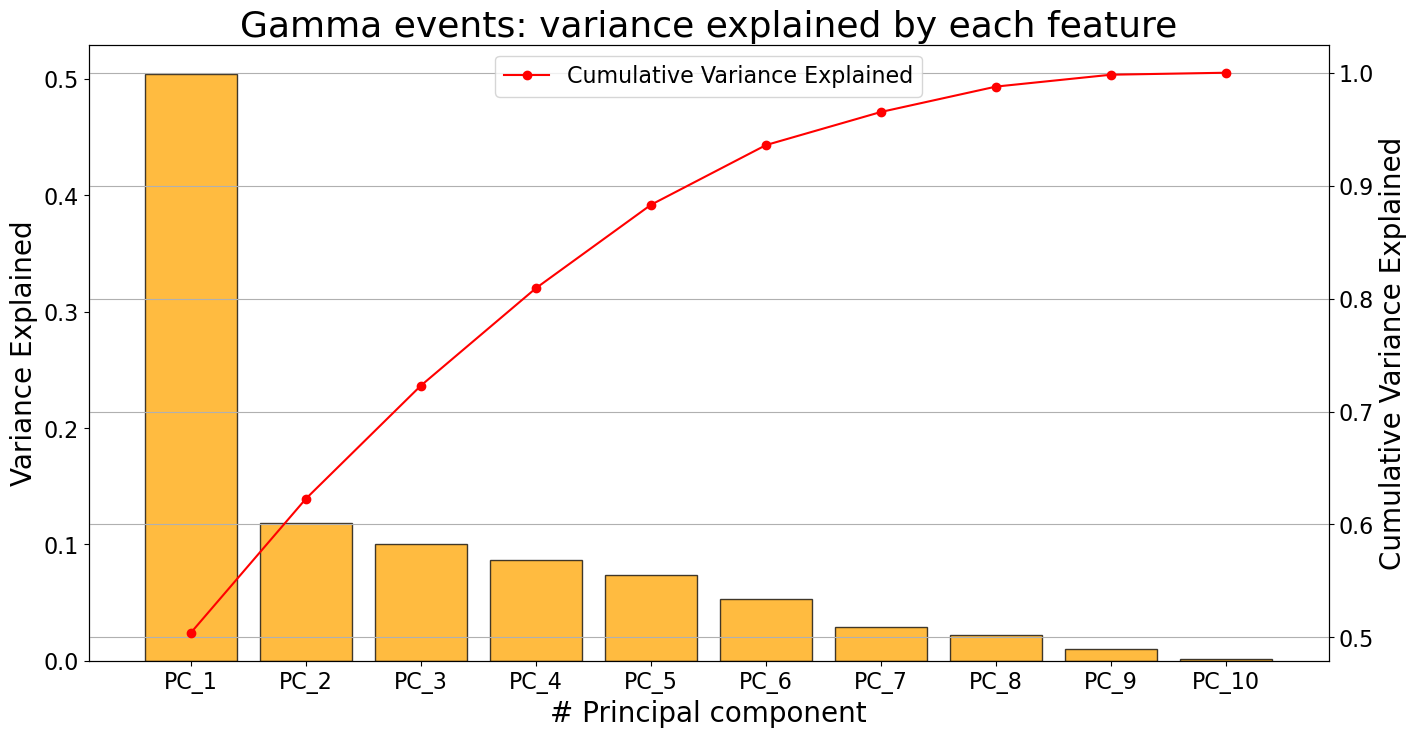

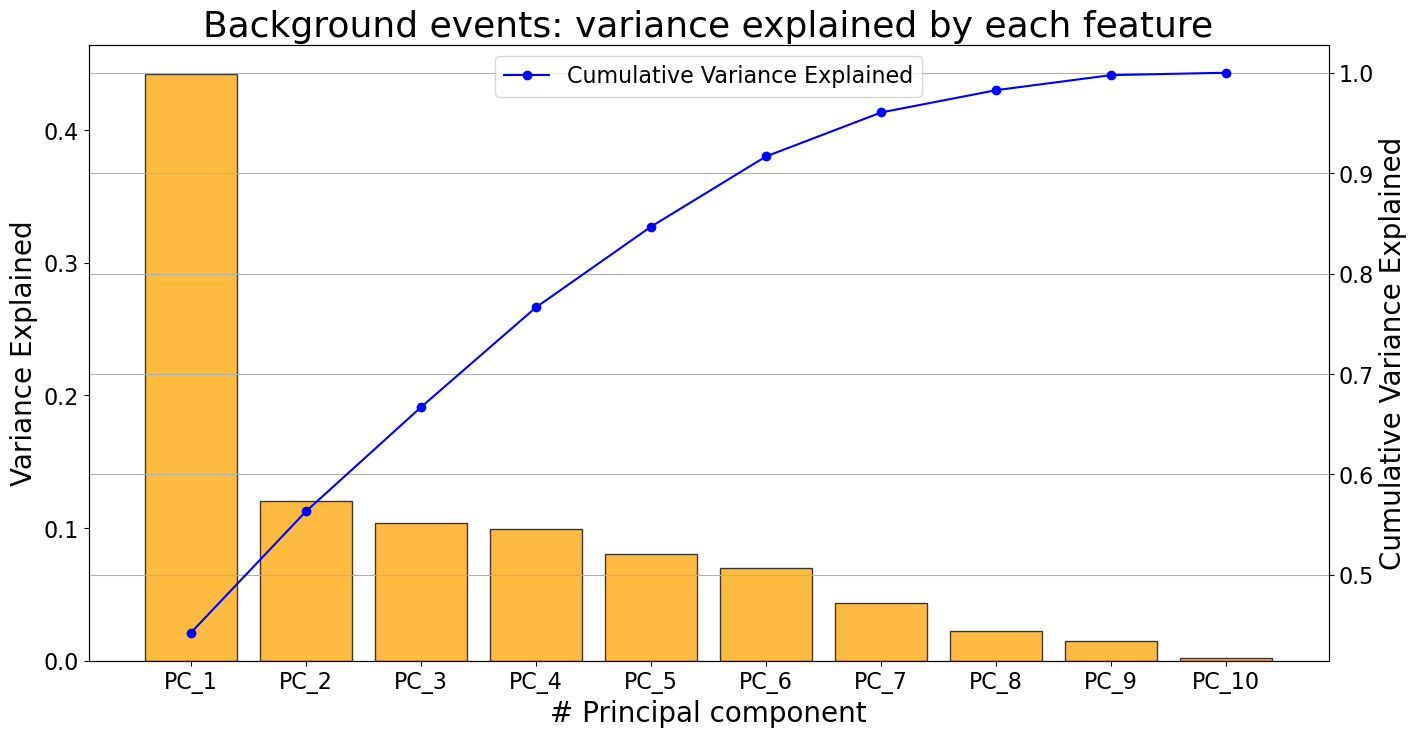

In [401]:
#GAMMA EVENTS
# sort eigenvalues in descending order and get sorted indices
sorted_indices = np.argsort(l_1)[::-1]
l_sorted = l_1[sorted_indices] 
 
variance_explained = l_sorted / np.sum(l_sorted) # ratio of the variance of the data explained by each feature

# cumulative variance explained
cumulative_variance = np.cumsum(variance_explained)

feature_names = df_1.columns.tolist()
pca_list = []
for i in range(len(feature_names)):
    pca_list.append(f'PC_{i+1}')

# features ordered from most important to least important to variability 
top_features = []
for i in range(len(feature_names)):
    most_important_feature_idx = sorted_indices[i]  # Index of the feature with the largest eigenvalue
    top_features.append(feature_names[most_important_feature_idx])

fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(pca_list, variance_explained, color='Orange', edgecolor='black',alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(pca_list, cumulative_variance, label='Cumulative Variance Explained', marker='o', color='red')

ax1.set_ylabel('Variance Explained',fontsize=20)
ax2.set_ylabel('Cumulative Variance Explained',fontsize=20)
ax1.set_xlabel('# Principal component',fontsize=20)

plt.title('Gamma events: variance explained by each feature',fontsize=26)
ax2.legend(loc='upper center',fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=45)  
ax1.tick_params(axis='y', labelsize=16)  
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
plt.grid()
plt.show()
print("\n")

#BACKGROUND EVENTS 
sorted_indices = np.argsort(l_0)[::-1]
l_sorted = l_0[sorted_indices] 
 
variance_explained = l_sorted / np.sum(l_sorted) # ratio of the variance of the data explained by each feature

# cumulative variance explained
cumulative_variance = np.cumsum(variance_explained)

feature_names = df_0.columns.tolist()

# features ordered from most important to least important to variability 
top_features = []
for i in range(len(feature_names)):
    most_important_feature_idx = sorted_indices[i]  # Index of the feature with the largest eigenvalue
    top_features.append(feature_names[most_important_feature_idx])

fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(pca_list, variance_explained, color='Orange', edgecolor='black',alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(pca_list, cumulative_variance, label='Cumulative Variance Explained', marker='o', color='blue')

ax1.set_ylabel('Variance Explained',fontsize=20)
ax1.set_xlabel('# Principal component',fontsize=20)
ax2.set_ylabel('Cumulative Variance Explained',fontsize=20)


plt.title('Background events: variance explained by each feature',fontsize=26)
ax2.legend(loc='upper center',fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=18)  
ax1.tick_params(axis='y', labelsize=16)  
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
plt.grid()
plt.show()

We notice that, for both signal and background events, the first principal component explains about half of the variance of the dataset, while the other component are responsible for about 10% at maximum. Being the principal components linear combinations of the features of the dataset, it is not possible to identify which features of the dataset are most influential. Therefore we perform the following analysis keeping the original dataset.

# Part 5: Machine Learning Analysis
In this section we are going to implement several ML algorithms to classify the data in signal and background classes. Metrics used to evaluate data are the area under ROC curve in the range [0-0.2] (false positive rate values), since we mostly want to avoid accpeting hadrons, and the quality factor $Q=\frac{\epsilon_{\gamma}}{\sqrt{\epsilon_h}}$, where ${\epsilon_{\gamma}}$ represents the fraction of correctly classified signals, and ${{\epsilon_h}}$ represents the fraction of hadrons classified as signals. Our objective is to correctly identify signals while also minimizing the false positives (background identified as signals). To this extent, our aim is maximizing area under the ROC curve and the quality factor Q, ignoring the fraction of gamma points classified as background. This way we ensure to have better quality results. 

The models are going to be trained on the training set with a K-fold. Moreover, a grid search on the hyperparameters is going to be run. 

## Part 5.1: Perceptron
The following code is about Perceptron algorithm. Scikit learn library is going to be used. Also, all the training is going to be performed keeping out the feature Alpha.

First, we associate +1 label to gammas and -1 label to hadrons. Then we split train and test set (20% of total data)

In [402]:
# Alpha has not to be normalized (reset to original value)
X_rescaled['fAlpha'] = original_alpha.copy()

new_Y = []

# gammas are +1    hadrons are -1

for i in range(len(Y)):
    if (Y.iloc[i] == 'g'):
        new_Y.append(1)
    if(Y.iloc[i] == 'h'):
        new_Y.append(-1)
        
Y_df = pd.DataFrame({'category' : new_Y})
data_rescaled_and_indexed = pd.merge(X_rescaled, Y_df,left_index=True, right_index=True)

# divide dataset in 5 parts, taking 1 as test set ( 20 % )
# remove alpha

parts_to_be_split = 5 
train_set, test_set = split_train_test_set( data_rescaled_and_indexed , parts_to_be_split )
train_alpha = train_set['fAlpha']
train_set = train_set.drop('fAlpha',axis=1)
test_alpha = test_set['fAlpha']
test_set = test_set.drop('fAlpha',axis=1)
X_train, Y_train = split_X_Y(train_set)
X_test, Y_test = split_X_Y(test_set)

print('Train set shapes:',np.shape(X_train),np.shape(Y_train))
print('Absolute and relative frequence of points in Training set:')
print(f'Signal: {len(Y_train[Y_train == 1])} points \t {round(len(Y_train[Y_train == 1])/len(Y_train)*100,2)}%')
print(f'Back: {len(Y_train[Y_train == -1])} points \t {round(len(Y_train[Y_train == -1])/len(Y_train)*100,2)}%\n')

print('Test set shapes:',np.shape(X_test),np.shape(Y_test))
print('Absolute and relative frequence of points in Test set:')
print(f'Signal: {len(Y_test[Y_test == 1])} points \t {round(len(Y_test[Y_test == 1])/len(Y_test)*100,2)}%')
print(f'Back: {len(Y_test[Y_test == -1])} points \t {round(len(Y_test[Y_test == -1])/len(Y_test)*100,2)}%\n')


Train set shapes: (15216, 9) (15216,)
Absolute and relative frequence of points in Training set:
Signal: 9868 points 	 64.85%
Back: 5348 points 	 35.15%

Test set shapes: (3803, 9) (3803,)
Absolute and relative frequence of points in Test set:
Signal: 2463 points 	 64.76%
Back: 1340 points 	 35.24%



The following cell performs the training. The parameters are set at the beginning and the best model criterion is the one that maximizes ROC area in range [0-0.2]

In [403]:
n_attempts = 10000
limit = 0.2 
best_scores = []
best_f = []
best_t = []
best_score = 0

# K fold definition
K = 5
limit = 0.2 
kf = KFold(n_splits=K, shuffle=True, random_state=42) 

#print('n_iter, score')
for i in range (n_attempts):
    auc_fold = 0
    filtered_auc_fold = 0
    
    state = abs(np.random.normal(size=1))
    state = int(state[0] * 1000000)
    perceptron = Perceptron(alpha=0.01,penalty='l2',max_iter=10000,tol=1e-4,random_state=state,n_iter_no_change=10)
    
    for train_idx, val_idx in kf.split(data_rescaled_and_indexed):  ###gets the index of training and validation set
                
        train_K=data_rescaled_and_indexed.iloc[train_idx]
        valid_K=data_rescaled_and_indexed.iloc[val_idx]
        X_train_K, Y_train_K = split_X_Y(train_K)
        X_valid_K, Y_valid_K = split_X_Y(valid_K)
    
    
        fitted = perceptron.fit(X_train_K,Y_train_K)
    
        decision_values = perceptron.decision_function(X_valid_K)

        fpr, tpr, thresholds = roc_curve(Y_valid_K, decision_values)
    
        # here i filter data to compute roc curve area for fpr in range 0 -> 0.8
        fpr_filtered = fpr[fpr <= limit]
        tpr_filtered = tpr[:len(fpr_filtered)]
    
        auc_filtered_K = np.trapz(tpr_filtered, fpr_filtered)
        auc_K = roc_auc_score(Y_valid_K, decision_values)
        auc_fold += auc_K / K
        filtered_auc_fold += auc_filtered_K / K
    
    # score is better if filtered is better, though saving all 
    if (filtered_auc_fold > best_score):
        best_score = filtered_auc_fold
        best_scores.append(auc_fold)
        #best_f.append(fpr)
        best_fpr = fpr
        best_tpr = tpr
        #best_t.append(tpr)
        best_perceptron = perceptron
        #print(i, auc)

print('Trained',n_attempts,'perceptrons')
print("best AUC-ROC Score:")
print(round(best_scores[len(best_scores)-1],3))

Trained 10000 perceptrons
best AUC-ROC Score:
0.798


Here we plot the confusion matrix for the best model:

In [404]:
def normalize_cm(cm):
    norm_cm = np.zeros(shape=(2,2))
    bkg = cm[0,0] + cm[0,1]  # first row is bkg
    sig = cm[1,0] + cm[1,1]  # second row is signal
    norm_cm[0,0] = round(cm[0,0] / bkg,3)
    norm_cm[0,1] = round(cm[0,1] / bkg,3)
    norm_cm[1,0] = round(cm[1,0] / sig,3)
    norm_cm[1,1] = round(cm[1,1] / sig,3)
    
    return norm_cm


def plot_cm(cm,method_name):
    fig = plt.figure()
    im = plt.imshow(cm, cmap='seismic',alpha=0.8, interpolation='nearest')
    plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
    plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = plt.text(j, i, format(cm[i, j], fmt),
            ha="center", va="center",
            color="white")
            text.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground='black')])
            
    fig.tight_layout()
    fig.colorbar(im, location = 'right') 

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.title(f'{method_name} confusion matrix')
    plt.show()

In [405]:
model = best_perceptron
best_perceptron.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

cm = confusion_matrix(Y_test,Y_pred)


Confusion matrix:
[[0.419 0.581]
 [0.268 0.732]]


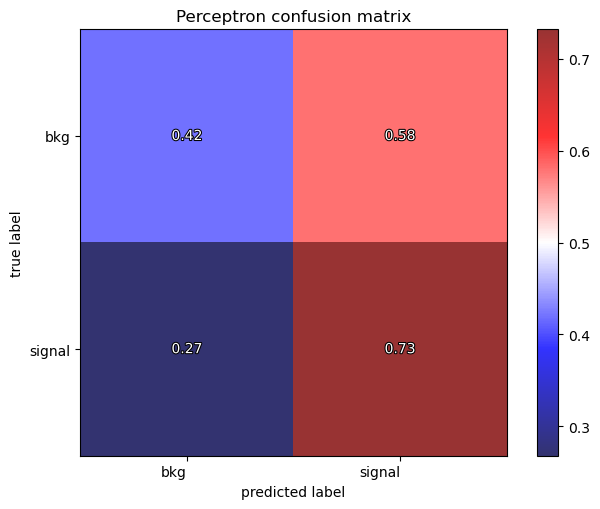

In [406]:
perceptron_cm = normalize_cm(cm)

print('Confusion matrix:')
print(perceptron_cm)
plot_cm(perceptron_cm,method_name='Perceptron')


In the end we take the ROC curve and the best Q value (the one closest to the point (0,1)). We save it in a variable that will be used later as confrontation.

Perceptron Q value: 0.96


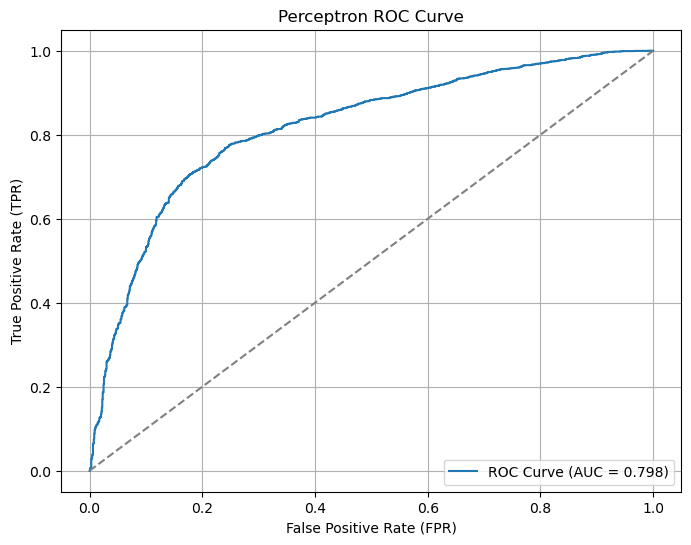

In [408]:
fig = plt.figure(figsize=(8, 6))

fpr_perceptron = best_fpr
tpr_perceptron = best_tpr

Q_perceptron = perceptron_cm[1][1]/ np.sqrt(perceptron_cm[0][1])
print('Perceptron Q value:',round(Q_perceptron,3))
plt.plot(fpr_perceptron, tpr_perceptron, label=f'ROC Curve (AUC = {best_scores[len(best_f)-1]:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('Perceptron ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();

## Part 5.2: Logistic Regression (version 3)

Logistic regression allows to pose a classification problem as a regression problem, where the predicted label is the probability for a sample to belong to a certain class. Thus, in our case the output of the algorithm is the *gammaness*. We can then choose a threshold for the *gammaness* to assign gamma (+1) as the predicted label. The learning problem is to find the sigmoid function
$\sigma_{\mathbf{w}}(\mathbf{x}) =\frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x})}}$
that minimizes the loss:

$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) + \lambda||\mathbf{w}||^2
$$
where: 
$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) = -\sum_{i=1}^{n} \left[ y_i \log(\sigma_{\mathbf{w}}(\mathbf{x}_i)) + (1 - y_i) \log(1 - \sigma_{\mathbf{w}}(\mathbf{x}_i)) \right]$$
and we use the Tikhonov regularization technique to prevent overfitting.

To find the best hyper-parameter $C=\frac{1}{\lambda}$ for model we choose the usual 0.5 threshold for the *gammaness* and perform a K-fold cross validation, where again we keep as best model the one that maximizes the partial AUC. 

In [427]:
# this function determines the partial area under the curve, up to FPR<=0.2
def partial_auc_at_fpr(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    valid_indices = fpr <= 0.2  # indices where FPR <= 0.2
    partial_fpr = fpr[valid_indices]
    partial_tpr = tpr[valid_indices]
    # check if there are at least 2 points for partial AUC calculation
    if len(partial_fpr) < 2:
        return 0  # return 0 if not enough points to calculate AUC

    partial_auc = auc(partial_fpr, partial_tpr)
    return partial_auc

def full_auc_scorer(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return auc(fpr, tpr)

# create scoring function (partial AUC) to implement a grid-search
partial_auc_scorer = make_scorer(partial_auc_at_fpr, greater_is_better=True)


In [474]:
auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict') 

# hyper-parameters 
param_grid = {'C': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]} # we use Tikhonov regularization: in the loss we add a term proportional to the norm squared of w (C=1/lambda)

# grid search with K-fold validation
K=5

fprs = []
tprs = []
aucs = []
partial_aucs = []
C = []
for c in param_grid['C']:
        auc_value=0
        partial_auc=0
        print(f"Training model with regularization constant c = {c}")
        C.append(c)
        for i in range(K):
            train_K, valid_K = split_train_test_set(train_set,K)
            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            model= LogisticRegression(penalty='l2',tol=1e-5,C=c,solver='lbfgs',max_iter=int(1e6)) # 'lbfgs' approximates up to the the second derivative of the loss function to optimize the coefficients, best for large datasets 
            model.fit(X_train_K,Y_train_K)
                    
            y_pred_proba = model.predict_proba(X_valid_K)[:, 1]  
            fpr, tpr, _ = roc_curve(Y_valid_K, y_pred_proba)
            fprs.append(fpr)
            tprs.append(tpr)
            auc_value_k = auc(fpr, tpr)
            # keep fpr less than 0.2 (if not able to find it, partial auc is set to zero)
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc=0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += auc_value_k/K
        print('Partial AUC:', partial_auc)
        partial_aucs.append(partial_auc)
        print('AUC:', auc_value,'\n')
        aucs.append(auc_value)                

Training model with regularization constant c = 0.001
Partial AUC: 0.04139197446904923
AUC: 0.6984437528875256 

Training model with regularization constant c = 0.005
Partial AUC: 0.04569182025028978
AUC: 0.7151156053890375 

Training model with regularization constant c = 0.01
Partial AUC: 0.04496026584990355
AUC: 0.7186701131844131 

Training model with regularization constant c = 0.05
Partial AUC: 0.04291911388505856
AUC: 0.7152189950861552 

Training model with regularization constant c = 0.1
Partial AUC: 0.042888681475701906
AUC: 0.7144333300790808 

Training model with regularization constant c = 0.5
Partial AUC: 0.042438078391245145
AUC: 0.7122828464709854 

Training model with regularization constant c = 1
Partial AUC: 0.04250136226929782
AUC: 0.7184956889989256 

Training model with regularization constant c = 5
Partial AUC: 0.04265953600960503
AUC: 0.7140485630175593 

Training model with regularization constant c = 10
Partial AUC: 0.044227372676915525
AUC: 0.7165388949097505

In [475]:
best_partial_auc = np.max(np.array(partial_aucs))
best_auc= np.max(np.array(aucs))
best_index = np.where(partial_aucs==best_partial_auc)[0]
print('Best model with regularization constant c=',C[best_index[0]])
print('Best partial AUC (validation set):', best_partial_auc)
print('AUC of best model (validation set):', best_auc,'\n')

best_model = LogisticRegression(penalty='l2', C= C[best_index[0]],solver='lbfgs',max_iter=300)
best_model.fit(X_train,Y_train) # retrain the best
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  
fpr_test, tpr_test, _ = roc_curve(Y_test, y_pred_proba_test)
auc_test= auc(fpr_test,tpr_test)

partial_fpr_test = fpr_test[fpr_test <= 0.2]
if (len(partial_fpr_test)<2):
    partial_auc_test=0
else:
    partial_tpr_test = tpr_test[:len(partial_fpr_test)]
    partial_auc_test = auc(partial_fpr_test, partial_tpr_test)
print('Best partial AUC (test set):', partial_auc_test)
print('AUC of best model (test set):', auc_test)

Best model with regularization constant c= 0.005
Best partial AUC (validation set): 0.04569182025028978
AUC of best model (validation set): 0.7186701131844131 

Best partial AUC (test set): 0.04235642736379006
AUC of best model (test set): 0.7039734336841977


Confusion matrix:
[[0.304 0.696]
 [0.041 0.959]]


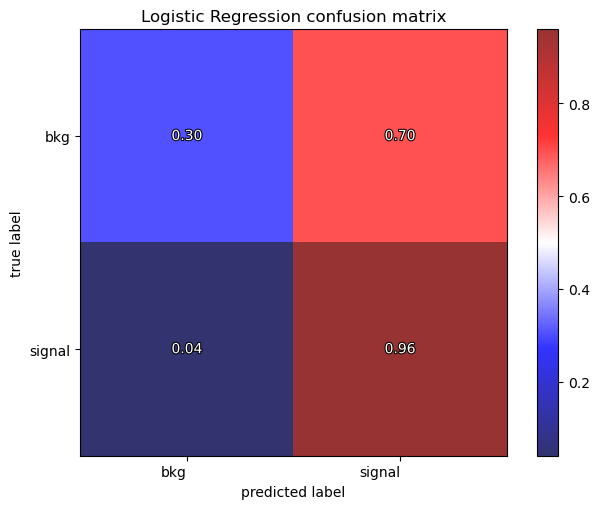

In [476]:
Y_pred = best_model.predict(X_test)
cm = confusion_matrix(Y_test,Y_pred)
log_cm = normalize_cm(cm)

print('Confusion matrix:')
print(log_cm)
plot_cm(log_cm,method_name='Logistic Regression')


Here we plot the best model for ROC curve

Q value of best model: 1.1495132653112086


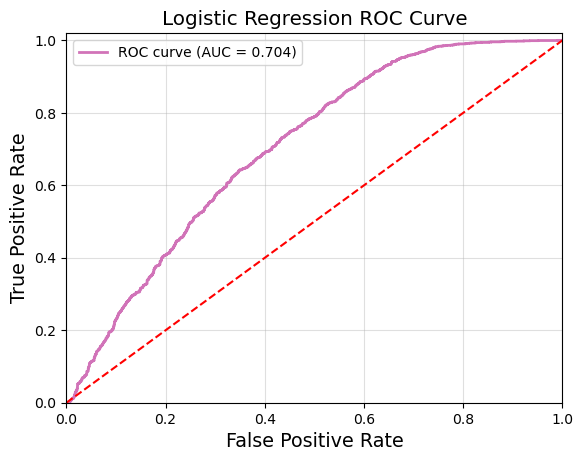

In [477]:
fpr_log = fpr_test
tpr_log = tpr_test
Q_log = log_cm[1][1]/ np.sqrt(log_cm[0][1])
print('Q value of best model:',Q_log)

plt.figure()
plt.plot(fpr_test, tpr_test, color='#d173b8', lw=2, label=f'ROC curve (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Logistic Regression ROC Curve',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()

Here we plot the two ROCs computed until now

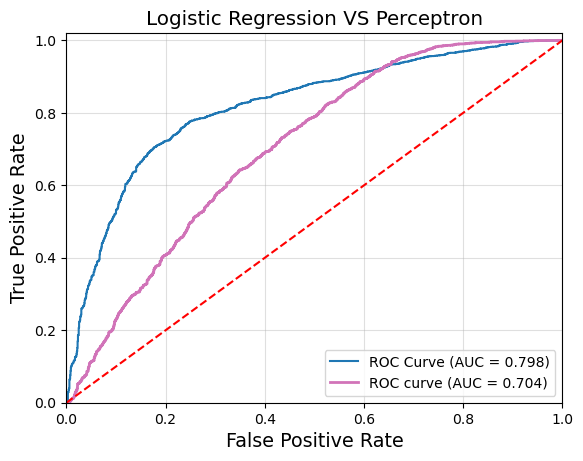

In [478]:
plt.figure()
plt.plot(fpr_perceptron, tpr_perceptron, label=f'ROC Curve (AUC = {best_scores[len(best_f)-1]:.3f})')
plt.plot(fpr_test, tpr_test, color='#d173b8', lw=2, label=f'ROC curve (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Logistic Regression VS Perceptron',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()

## Part 5.3: SVM
In this part the same dataset is analyzed with soft SVM. Different kernels are tried (linear,poly with deg 3,rbf and sigmoid), as well as different values for parameters such as nu and gamma

In [409]:
alphaCol = data_rescaled_and_indexed['fAlpha'] 
data_rescaled_and_indexed = data_rescaled_and_indexed.drop('fAlpha',axis = 1)
print(np.shape(data_rescaled_and_indexed))

(19019, 10)


In [412]:
# list with all possible kernels (poly uses deg = 3 as standard value)
kernels = ['linear','poly','rbf','sigmoid']


# list with all nu values (upper bound on fraction of margin errors)
nus = [ 0.5 , 0.1 , 0.05 , 0.01 ]

# list with all gamma values (by default is 1/(n_features*X.var()) )
gammas = [ 0.1, 0.01, 0.001, 0.0001 ]

best_auc_score = 0

# tolerance for stopping criteria (default is 1e-3) (default max_iter is inf)
tolerance = 1e-6
max_iter = int(2e4)

# K fold definition
K = 5
limit = 0.2 
kf = KFold(n_splits=K, shuffle=True, random_state=42) 
kFoldInfo = 0

start_time = time()


for kernel_type in kernels:
    for nu in nus:
        for gamma in gammas:
            print(f'training SVM with {kernel_type} kernel...')
            partial_auc = 0
            auc_value = 0
            for train_idx, val_idx in kf.split(data_rescaled_and_indexed):  ###gets the index of training and validation set
                
                train_K=data_rescaled_and_indexed.iloc[train_idx]
                valid_K=data_rescaled_and_indexed.iloc[val_idx]
                X_train_K, Y_train_K = split_X_Y(train_K)
                X_valid_K, Y_valid_K = split_X_Y(valid_K)
                
                if kFoldInfo == 0:
                    print("Train fold size:",np.shape(X_train_K),"\t Test fold size:",np.shape(X_valid_K))
                    KFoldInfo = 1
                
                clf = make_pipeline(StandardScaler(), NuSVC(nu=nu,kernel=kernel_type,gamma=gamma,probability=True,tol=tolerance,max_iter=max_iter),verbose=False)
    
                fitted = clf.fit(X_train_K, Y_train_K)
                pred = clf.predict(X_valid_K)
                errors = np.sum(pred != Y_valid_K) / len(Y_valid_K)
                
                pred_prob = clf.predict_proba(X_valid_K)[:, 1]
                fpr, tpr, thresholds = roc_curve(Y_valid_K, pred_prob)
                
                auc_value_k = auc(fpr, tpr)
                fpr_filtered = fpr[fpr <= limit]

                if (len(fpr_filtered) < 2 ):
                    partial_auc=0
                else:
                    tpr_filtered = tpr[:len(fpr_filtered)]
                    partial_auc_k = np.trapz(fpr_filtered, tpr_filtered)
                partial_auc += partial_auc_k/K
                auc_value += auc_value_k/K                 
            if(partial_auc > best_auc_score):
                best_auc_score = partial_auc
                best_model = clf
                best_tpr = tpr
                best_fpr = fpr
                best_auc = auc_value
                best_kernel = kernel_type
                best_nu = nu
                best_gamma = gamma
                print(partial_auc.round(3),best_auc.round(3), kernel_type, nu, gamma)
            print('elapsed time:',round(time()-start_time,3),'s')
            start_time = time()

print('best results are for')
print('kernel:',best_kernel,'nu:',best_nu,'gamma:',best_gamma,'with auc:',best_auc)


training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
0.022 0.505 linear 0.5 0.1
elapsed time: 136.013 s
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
0.026 0.554 linear 0.5 0.01
elapsed time: 124.198 s
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fo

elapsed time: 16.006 s
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 50.023 s
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 49.41 s
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (38

Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 312.936 s
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 269.055 s
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 218.827 s
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test f

Here we have the confusion matrix

Confusion matrix:
[[0.494 0.506]
 [0.034 0.966]]


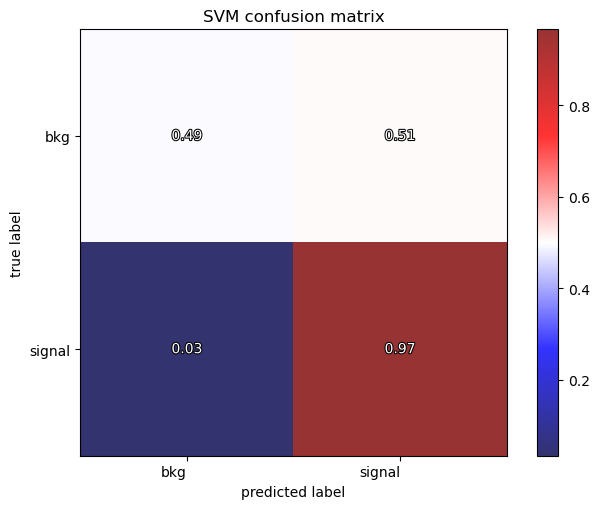

In [413]:
best_pred = best_model.predict(X_test)
cm = confusion_matrix(Y_test,best_pred)
SVM_cm = normalize_cm(cm)

print('Confusion matrix:')
print(SVM_cm)
plot_cm(SVM_cm,method_name='SVM')


The best curve is then plotted and saved

best SVM Q value: 1.3580065604340128


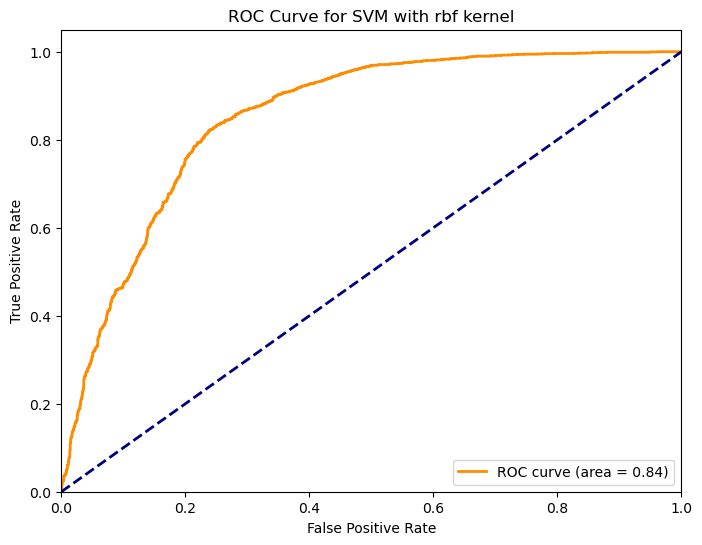

In [414]:
tpr_SVM = best_tpr
fpr_SVM = best_fpr
Q_SVM = get_best_Q(fpr_SVM,tpr_SVM)
Q_SVM = SVM_cm[1][1]/ np.sqrt(SVM_cm[0][1])


print('best SVM Q value:',Q_SVM)
plt.figure(figsize=(8, 6))
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % best_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for SVM with {best_kernel} kernel')
plt.legend(loc='lower right')
plt.show();

Let's check how SVM performed in comparison to Perceptron

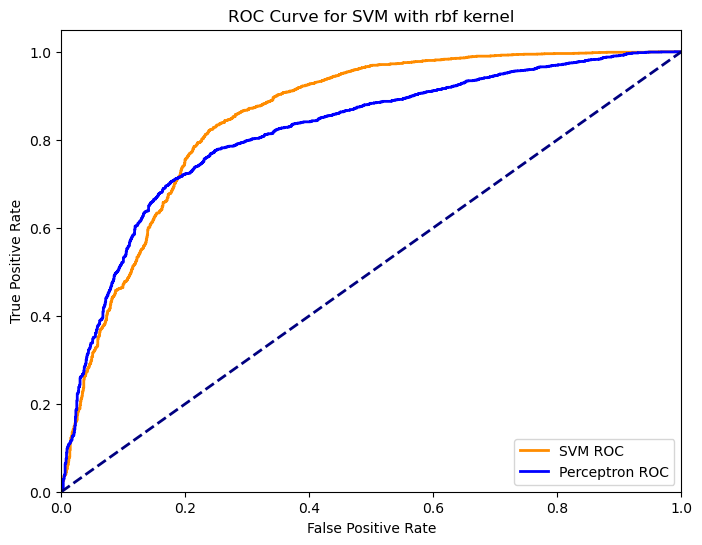

In [415]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_SVM, tpr_SVM, color='darkorange', lw=2, label='SVM ROC' % best_auc)
plt.plot(fpr_perceptron, tpr_perceptron, color='blue', lw=2, label='Perceptron ROC' % best_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for SVM with {best_kernel} kernel')
plt.legend(loc='lower right')
plt.show();

## Part 5.4: Random Forest
Here we are going to implement a Random Forest classification algorithm. A Random Forest is composed of different decision tree predictors. For each tree, at each iteration, the data are split into two branches according to a threshold value for one of the features. At each split, the best feature and the best threshold value are chosen by minimizing the entropy function 
𝐻 given by:
$$
\displaystyle H = - \sum_{i=+1,-1} f_i \log_2(f_i)
$$
where $f_i$ is the fraction of points of class $i=+1,-1$ in the training set. The splitting continues until either a maximum depth for the tree is reached, in which case the most frequent class of the branch is assigned to all points, or the points of the branch all belong to the same class (in this case the branch is called a leaf). Different trees are built by randomly drawing data with replacement from the test set, applying the algorithm to each tree. The final label for a point is chosen based on a majority vote of the trees results. 

The hyper-parameters of the model are the **number of trees** and the **maximum depth** of the trees. We are going to implement a K-fold cross validation to choose as best hyper-parameters the ones that maximize the area under the ROC curve of the classifier. To build the ROC curve we need to estimate the probability for the points to belong to a certain class. This can be done because each tree, at the last decision step, assigns a class label based on the majority class of the training samples that reached that final leaf node, but also keeps track of the proportion of the classes in that leaf node. For example, suppose a test point ends up in a leaf node where, out of 100 training samples that ended up there, 80 belonged to class 1 and 20 belonged to class -1. The probability of the point belonging to class 1 would be 0.8, while the probability of it belonging to class -1 would be 0.2.\

We will use the class `RandomForestClassifier` from `scikit-learn` to implement and train the Forest and to predict the labels with their probabilities.   


\
**DA METTERE QUANDO SI INTRODUCE IL CONCETTO DI ROC CURVE?**
The ROC curve plots the True Positive Rate (TPR), i.e: the fraction of actual gamma samples correctly identified as gamma, versus the False Positive Rate, i.e: the fraction of actual hadrons incorrectly classified as gamma by the model. To do so, it's necessary to estimate a probability for the predicted class, not just to assign the predicted label. Imposing different threshold values on the probability for the acceptance of an event as either gamma or hadron, we can obtain the ROC curve.   \
\


In [416]:
from time import time

num_trees= np.arange(40,300,10)
max_depth= np.arange(10,40,2)
accuracies=[]
roc_areas=[]
best_area=0
best_acc=0
best_model= [] # stores best number of trees and best max depth
partial_aucs = []

start_time = time()

max_iter = len(num_trees) * len(max_depth)
iteration = 0

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42) 

for tree in num_trees:
    for depth in max_depth:
        ############accuracies?
        partial_auc = 0
        auc_value = 0
        accuracy = 0
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            print(f"  Fold n. {i}")
            train_K=data_rescaled_and_indexed.iloc[train_idx]
            valid_K = data_rescaled_and_indexed.iloc[test_index]

            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            forest = RandomForestClassifier(n_estimators=tree,  # number of trees
                                           max_depth= depth, 
                                           max_features=X_train.shape[1],   # number of features for each split (random subset)
                                           bootstrap=True,    # bagging (sampling with replacement)
                                           max_samples=1.0,   # percentage of samples to use for each tree (100% of data)
                                           random_state=10,
                                           n_jobs=-1)
            # train each model, predict labels and probability of each label
            forest.fit(X_train_K, Y_train_K)
            Y_pred = forest.predict(X_valid_K)
            y_pred_prob = forest.predict_proba(X_valid_K)[:, 1] # probability for the validation points to belong to class +1 or -1
            # accuracy on validation set
            accuracy_k = accuracy_score(Y_valid_K, Y_pred)
            iteration +=1 
            print(f'elapsed time: {round(time()-start_time,2)}s, done {iteration} out of {max_iter*K}')
            print('Number of trees:',tree,', Maximum depth',depth,':') 
            print('Accuracy:',accuracy_k)
            # false positive rates and the true positive rates for different threshold values 
            fpr, tpr, thresholds = roc_curve(Y_valid_K, y_pred_prob)

            # area under the ROC curve on validation set 
            roc_auc_k = auc(fpr, tpr)
            roc_areas.append(roc_auc_k)
            '''if(roc_auc>best_area):
                best_area= roc_auc
                best_acc= accuracy
                best_model=[tree,depth]
                '''
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc = 0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += roc_auc_k/K
        
        partial_aucs.append(partial_auc)
        if(partial_auc>best_area):
            best_area= partial_auc
            best_total_auc = auc_value
            best_acc= accuracy
            best_model=[tree,depth]
        print('\033[91mArea under ROC curve:',round(auc_value,3),'Selected area:',round(partial_auc,3),'\033[0m')
        print('\n')
        
print('Best number of trees:', best_model[0],'\n')
print('Best maximum depth:', best_model[1],'\n')
print('Area under ROC curve of best model:',best_area)

  Fold n. 0
elapsed time: 1.1s, done 1 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8554153522607781
  Fold n. 1
elapsed time: 2.14s, done 2 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8509463722397477
  Fold n. 2
elapsed time: 3.09s, done 3 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.861198738170347
  Fold n. 3
elapsed time: 4.0s, done 4 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8470031545741324
  Fold n. 4
elapsed time: 4.95s, done 5 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8146200368130423
Area under ROC curve: 0.894 Selected area: 0.111 


  Fold n. 0
elapsed time: 6.16s, done 6 out of 1950
Number of trees: 40 , Maximum depth 12 :
Accuracy: 0.8824921135646687
  Fold n. 1
elapsed time: 7.35s, done 7 out of 1950
Number of trees: 40 , Maximum depth 12 :
Accuracy: 0.8777602523659306
  Fold n. 2
elapsed time: 8.5s, done 8 out of 1950
Number of trees: 40 , Maximum depth 12 :
Accur

elapsed time: 99.41s, done 62 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 0.9994742376445847
  Fold n. 2
elapsed time: 101.46s, done 63 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 0.9989484752891693
  Fold n. 3
elapsed time: 103.28s, done 64 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 105.07s, done 65 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 0.8348672100972916
Area under ROC curve: 0.976 Selected area: 0.166 


  Fold n. 0
elapsed time: 107.01s, done 66 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accuracy: 0.9994742376445847
  Fold n. 1
elapsed time: 109.15s, done 67 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accuracy: 0.9994742376445847
  Fold n. 2
elapsed time: 110.92s, done 68 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accuracy: 0.9989484752891693
  Fold n. 3
elapsed time: 112.77s, done 69 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accur

elapsed time: 227.19s, done 122 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.9926393270241851
  Fold n. 2
elapsed time: 230.0s, done 123 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.9971083070452156
  Fold n. 3
elapsed time: 232.82s, done 124 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.9957939011566772
  Fold n. 4
elapsed time: 235.55s, done 125 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.8409150670523271
Area under ROC curve: 0.976 Selected area: 0.177 


  Fold n. 0
elapsed time: 238.33s, done 126 out of 1950
Number of trees: 50 , Maximum depth 30 :
Accuracy: 0.9971083070452156
  Fold n. 1
elapsed time: 241.21s, done 127 out of 1950
Number of trees: 50 , Maximum depth 30 :
Accuracy: 0.9965825446898002
  Fold n. 2
elapsed time: 244.16s, done 128 out of 1950
Number of trees: 50 , Maximum depth 30 :
Accuracy: 0.9986855941114616
  Fold n. 3
elapsed time: 247.02s, done 129 out of 1950
Number of trees: 50 , M

elapsed time: 390.02s, done 182 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.9713459516298633
  Fold n. 2
elapsed time: 393.08s, done 183 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.9742376445846478
  Fold n. 3
elapsed time: 396.06s, done 184 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.9687171398527865
  Fold n. 4
elapsed time: 399.12s, done 185 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.834341309492506
Area under ROC curve: 0.975 Selected area: 0.166 


  Fold n. 0
elapsed time: 402.25s, done 186 out of 1950
Number of trees: 60 , Maximum depth 24 :
Accuracy: 0.9810725552050473
  Fold n. 1
elapsed time: 405.34s, done 187 out of 1950
Number of trees: 60 , Maximum depth 24 :
Accuracy: 0.981335436382755
  Fold n. 2
elapsed time: 408.39s, done 188 out of 1950
Number of trees: 60 , Maximum depth 24 :
Accuracy: 0.9852786540483701
  Fold n. 3
elapsed time: 411.67s, done 189 out of 1950
Number of trees: 60 , Ma

elapsed time: 571.32s, done 242 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.9282334384858044
  Fold n. 2
elapsed time: 574.28s, done 243 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.9295478443743428
  Fold n. 3
elapsed time: 577.36s, done 244 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.92534174553102
  Fold n. 4
elapsed time: 580.43s, done 245 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.8317118064685775
Area under ROC curve: 0.959 Selected area: 0.157 


  Fold n. 0
elapsed time: 583.61s, done 246 out of 1950
Number of trees: 70 , Maximum depth 18 :
Accuracy: 0.9413774973711883
  Fold n. 1
elapsed time: 586.78s, done 247 out of 1950
Number of trees: 70 , Maximum depth 18 :
Accuracy: 0.9463722397476341
  Fold n. 2
elapsed time: 590.07s, done 248 out of 1950
Number of trees: 70 , Maximum depth 18 :
Accuracy: 0.9471608832807571
  Fold n. 3
elapsed time: 593.37s, done 249 out of 1950
Number of trees: 70 , Ma

elapsed time: 785.51s, done 303 out of 1950
Number of trees: 80 , Maximum depth 10 :
Accuracy: 0.8638275499474237
  Fold n. 3
elapsed time: 787.99s, done 304 out of 1950
Number of trees: 80 , Maximum depth 10 :
Accuracy: 0.8480546792849631
  Fold n. 4
elapsed time: 790.52s, done 305 out of 1950
Number of trees: 80 , Maximum depth 10 :
Accuracy: 0.8190901919537208
Area under ROC curve: 0.896 Selected area: 0.113 


  Fold n. 0
elapsed time: 793.4s, done 306 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.8830178759200841
  Fold n. 1
elapsed time: 796.19s, done 307 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.8780231335436383
  Fold n. 2
elapsed time: 799.05s, done 308 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.8851209253417456
  Fold n. 3
elapsed time: 801.84s, done 309 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.880651945320715
  Fold n. 4
elapsed time: 804.65s, done 310 out of 1950
Number of trees: 80 , Ma

elapsed time: 1008.89s, done 363 out of 1950
Number of trees: 80 , Maximum depth 34 :
Accuracy: 0.9997371188222923
  Fold n. 3
elapsed time: 1013.29s, done 364 out of 1950
Number of trees: 80 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 1017.4s, done 365 out of 1950
Number of trees: 80 , Maximum depth 34 :
Accuracy: 0.8388114646331843
Area under ROC curve: 0.976 Selected area: 0.172 


  Fold n. 0
elapsed time: 1021.59s, done 366 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 1025.9s, done 367 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 1030.05s, done 368 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 1034.24s, done 369 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 1038.37s, done 370 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 0.837759663423613
Area under ROC curve: 

elapsed time: 1248.54s, done 423 out of 1950
Number of trees: 90 , Maximum depth 28 :
Accuracy: 0.9973711882229233
  Fold n. 3
elapsed time: 1253.24s, done 424 out of 1950
Number of trees: 90 , Maximum depth 28 :
Accuracy: 0.9971083070452156
  Fold n. 4
elapsed time: 1257.95s, done 425 out of 1950
Number of trees: 90 , Maximum depth 28 :
Accuracy: 0.8374967131212201
Area under ROC curve: 0.976 Selected area: 0.177 


  Fold n. 0
elapsed time: 1262.56s, done 426 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9981598317560463
  Fold n. 1
elapsed time: 1267.26s, done 427 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9973711882229233
  Fold n. 2
elapsed time: 1272.02s, done 428 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9989484752891693
  Fold n. 3
elapsed time: 1276.64s, done 429 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9994742376445847
  Fold n. 4
elapsed time: 1281.42s, done 430 out of 1950
Number of tree

elapsed time: 1509.32s, done 483 out of 1950
Number of trees: 100 , Maximum depth 22 :
Accuracy: 0.9752891692954785
  Fold n. 3
elapsed time: 1514.14s, done 484 out of 1950
Number of trees: 100 , Maximum depth 22 :
Accuracy: 0.9716088328075709
  Fold n. 4
elapsed time: 1518.93s, done 485 out of 1950
Number of trees: 100 , Maximum depth 22 :
Accuracy: 0.8351301603996845
Area under ROC curve: 0.975 Selected area: 0.175 


  Fold n. 0
elapsed time: 1523.84s, done 486 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.980546792849632
  Fold n. 1
elapsed time: 1528.76s, done 487 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.982124079915878
  Fold n. 2
elapsed time: 1533.73s, done 488 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.9858044164037855
  Fold n. 3
elapsed time: 1538.71s, done 489 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.9808096740273397
  Fold n. 4
elapsed time: 1543.67s, done 490 out of 1950
Number of

elapsed time: 1795.28s, done 543 out of 1950
Number of trees: 110 , Maximum depth 16 :
Accuracy: 0.9303364879074658
  Fold n. 3
elapsed time: 1799.91s, done 544 out of 1950
Number of trees: 110 , Maximum depth 16 :
Accuracy: 0.9277076761303891
  Fold n. 4
elapsed time: 1804.56s, done 545 out of 1950
Number of trees: 110 , Maximum depth 16 :
Accuracy: 0.8319747567709703
Area under ROC curve: 0.96 Selected area: 0.155 


  Fold n. 0
elapsed time: 1809.35s, done 546 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.9421661409043113
  Fold n. 1
elapsed time: 1814.3s, done 547 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.944006309148265
  Fold n. 2
elapsed time: 1819.11s, done 548 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.9476866456361724
  Fold n. 3
elapsed time: 1823.94s, done 549 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.9450578338590957
  Fold n. 4
elapsed time: 1828.76s, done 550 out of 1950
Number of 

elapsed time: 2115.62s, done 603 out of 1950
Number of trees: 120 , Maximum depth 10 :
Accuracy: 0.8640904311251314
  Fold n. 3
elapsed time: 2119.25s, done 604 out of 1950
Number of trees: 120 , Maximum depth 10 :
Accuracy: 0.8483175604626709
  Fold n. 4
elapsed time: 2122.85s, done 605 out of 1950
Number of trees: 120 , Maximum depth 10 :
Accuracy: 0.8193531422561136
Area under ROC curve: 0.898 Selected area: 0.113 


  Fold n. 0
elapsed time: 2126.93s, done 606 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8835436382754994
  Fold n. 1
elapsed time: 2131.09s, done 607 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8774973711882229
  Fold n. 2
elapsed time: 2135.33s, done 608 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8856466876971609
  Fold n. 3
elapsed time: 2139.53s, done 609 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8796004206098843
  Fold n. 4
elapsed time: 2143.62s, done 610 out of 1950
Number 

elapsed time: 2437.14s, done 662 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 0.9997371188222923
  Fold n. 2
elapsed time: 2443.26s, done 663 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 2449.37s, done 664 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 2455.79s, done 665 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 0.8372337628188272
Area under ROC curve: 0.976 Selected area: 0.178 


  Fold n. 0
elapsed time: 2462.03s, done 666 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 2468.16s, done 667 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 2474.24s, done 668 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 2480.34s, done 669 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 

elapsed time: 2777.6s, done 722 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.9931650893796005
  Fold n. 2
elapsed time: 2784.14s, done 723 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.9973711882229233
  Fold n. 3
elapsed time: 2790.67s, done 724 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.9976340694006309
  Fold n. 4
elapsed time: 2797.22s, done 725 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.8348672100972916
Area under ROC curve: 0.977 Selected area: 0.179 


  Fold n. 0
elapsed time: 2803.91s, done 726 out of 1950
Number of trees: 130 , Maximum depth 30 :
Accuracy: 0.9986855941114616
  Fold n. 1
elapsed time: 2810.47s, done 727 out of 1950
Number of trees: 130 , Maximum depth 30 :
Accuracy: 0.9976340694006309
  Fold n. 2
elapsed time: 2817.1s, done 728 out of 1950
Number of trees: 130 , Maximum depth 30 :
Accuracy: 0.999211356466877
  Fold n. 3
elapsed time: 2823.97s, done 729 out of 1950
Number of 

elapsed time: 3151.57s, done 783 out of 1950
Number of trees: 140 , Maximum depth 22 :
Accuracy: 0.9758149316508938
  Fold n. 3
elapsed time: 3158.15s, done 784 out of 1950
Number of trees: 140 , Maximum depth 22 :
Accuracy: 0.9710830704521556
  Fold n. 4
elapsed time: 3164.78s, done 785 out of 1950
Number of trees: 140 , Maximum depth 22 :
Accuracy: 0.834341309492506
Area under ROC curve: 0.976 Selected area: 0.116 


  Fold n. 0
elapsed time: 3171.62s, done 786 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.982124079915878
  Fold n. 1
elapsed time: 3178.41s, done 787 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.9818611987381703
  Fold n. 2
elapsed time: 3185.29s, done 788 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.9868559411146162
  Fold n. 3
elapsed time: 3192.05s, done 789 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.9789695057833859
  Fold n. 4
elapsed time: 3198.81s, done 790 out of 1950
Number of

elapsed time: 3547.28s, done 844 out of 1950
Number of trees: 150 , Maximum depth 16 :
Accuracy: 0.9274447949526814
  Fold n. 4
elapsed time: 3553.53s, done 845 out of 1950
Number of trees: 150 , Maximum depth 16 :
Accuracy: 0.8311859058637917
Area under ROC curve: 0.96 Selected area: 0.157 


  Fold n. 0
elapsed time: 3560.02s, done 846 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.9426919032597266
  Fold n. 1
elapsed time: 3566.52s, done 847 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.9453207150368034
  Fold n. 2
elapsed time: 3573.17s, done 848 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.9474237644584648
  Fold n. 3
elapsed time: 3579.8s, done 849 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.944794952681388
  Fold n. 4
elapsed time: 3586.29s, done 850 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.8332895082829346
Area under ROC curve: 0.969 Selected area: 0.132 


  Fold n. 0
ela

elapsed time: 3981.34s, done 905 out of 1950
Number of trees: 160 , Maximum depth 10 :
Accuracy: 0.8190901919537208
Area under ROC curve: 0.898 Selected area: 0.114 


  Fold n. 0
elapsed time: 3986.74s, done 906 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8838065194532071
  Fold n. 1
elapsed time: 3992.25s, done 907 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8793375394321766
  Fold n. 2
elapsed time: 3997.59s, done 908 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8859095688748686
  Fold n. 3
elapsed time: 4003.07s, done 909 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 4
elapsed time: 4008.44s, done 910 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8246121483039706
Area under ROC curve: 0.925 Selected area: 0.133 


  Fold n. 0
elapsed time: 4014.43s, done 911 out of 1950
Number of trees: 160 , Maximum depth 14 :
Accuracy: 0.9045741324921136
  Fold n. 1


elapsed time: 4418.95s, done 965 out of 1950
Number of trees: 160 , Maximum depth 34 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 4427.0s, done 966 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 4435.03s, done 967 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 4443.03s, done 968 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 4451.26s, done 969 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 4459.26s, done 970 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.977 Selected area: 0.178 


  Fold n. 0
elapsed time: 4467.27s, done 971 out of 1950
Number of trees: 160 , Maximum depth 38 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 4475.43s, done 972 out of 1950
Number of trees: 160 , Maximum dep

elapsed time: 4862.92s, done 1025 out of 1950
Number of trees: 170 , Maximum depth 28 :
Accuracy: 0.8380226137260058
Area under ROC curve: 0.977 Selected area: 0.179 


  Fold n. 0
elapsed time: 4871.46s, done 1026 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9986855941114616
  Fold n. 1
elapsed time: 4879.98s, done 1027 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9978969505783386
  Fold n. 2
elapsed time: 4888.5s, done 1028 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9994742376445847
  Fold n. 3
elapsed time: 4897.12s, done 1029 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9997371188222923
  Fold n. 4
elapsed time: 4905.71s, done 1030 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 4914.47s, done 1031 out of 1950
Number of trees: 170 , Maximum depth 32 :
Accuracy: 1.0
  Fold n. 1
elapsed tim

elapsed time: 5327.05s, done 1085 out of 1950
Number of trees: 180 , Maximum depth 22 :
Accuracy: 0.8372337628188272
Area under ROC curve: 0.976 Selected area: 0.105 


  Fold n. 0
elapsed time: 5335.78s, done 1086 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.9818611987381703
  Fold n. 1
elapsed time: 5344.42s, done 1087 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.982124079915878
  Fold n. 2
elapsed time: 5353.33s, done 1088 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.9860672975814931
  Fold n. 3
elapsed time: 5361.95s, done 1089 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.9802839116719243
  Fold n. 4
elapsed time: 5370.63s, done 1090 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.976 Selected area: 0.153 


  Fold n. 0
elapsed time: 5379.64s, done 1091 out of 1950
Number of trees: 180 , Maximum depth 26 :
Accuracy: 0.9897476340694006
  Fold 

elapsed time: 5821.17s, done 1145 out of 1950
Number of trees: 190 , Maximum depth 16 :
Accuracy: 0.8338154088877202
Area under ROC curve: 0.96 Selected area: 0.155 


  Fold n. 0
elapsed time: 5829.28s, done 1146 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.9421661409043113
  Fold n. 1
elapsed time: 5837.43s, done 1147 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.944794952681388
  Fold n. 2
elapsed time: 5845.59s, done 1148 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.9468980021030494
  Fold n. 3
elapsed time: 5853.75s, done 1149 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.944006309148265
  Fold n. 4
elapsed time: 5862.01s, done 1150 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.8348672100972916
Area under ROC curve: 0.969 Selected area: 0.13 


  Fold n. 0
elapsed time: 5870.55s, done 1151 out of 1950
Number of trees: 190 , Maximum depth 20 :
Accuracy: 0.9568874868559412
  Fold n.

elapsed time: 6357.19s, done 1205 out of 1950
Number of trees: 200 , Maximum depth 10 :
Accuracy: 0.8180383907441493
Area under ROC curve: 0.898 Selected area: 0.113 


  Fold n. 0
elapsed time: 6363.87s, done 1206 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8840694006309149
  Fold n. 1
elapsed time: 6370.47s, done 1207 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 2
elapsed time: 6377.1s, done 1208 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8874868559411146
  Fold n. 3
elapsed time: 6383.91s, done 1209 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.879863301787592
  Fold n. 4
elapsed time: 6390.72s, done 1210 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8275046016302918
Area under ROC curve: 0.925 Selected area: 0.133 


  Fold n. 0
elapsed time: 6398.28s, done 1211 out of 1950
Number of trees: 200 , Maximum depth 14 :
Accuracy: 0.9056256572029443
  Fold 

elapsed time: 6893.64s, done 1264 out of 1950
Number of trees: 200 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 6905.09s, done 1265 out of 1950
Number of trees: 200 , Maximum depth 34 :
Accuracy: 0.83933736523797
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 6915.41s, done 1266 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 6925.98s, done 1267 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 6936.26s, done 1268 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 6946.71s, done 1269 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 6956.97s, done 1270 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 0.8403891664475415
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 6967.24s, done 1271 out of 1950
Number of trees: 200 , Max

elapsed time: 7446.01s, done 1324 out of 1950
Number of trees: 210 , Maximum depth 28 :
Accuracy: 0.9971083070452156
  Fold n. 4
elapsed time: 7456.38s, done 1325 out of 1950
Number of trees: 210 , Maximum depth 28 :
Accuracy: 0.8406521167499342
Area under ROC curve: 0.977 Selected area: 0.178 


  Fold n. 0
elapsed time: 7466.9s, done 1326 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.998422712933754
  Fold n. 1
elapsed time: 7477.35s, done 1327 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.9976340694006309
  Fold n. 2
elapsed time: 7487.95s, done 1328 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.999211356466877
  Fold n. 3
elapsed time: 7498.46s, done 1329 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.9997371188222923
  Fold n. 4
elapsed time: 7508.87s, done 1330 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.8388114646331843
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n.

elapsed time: 8013.03s, done 1384 out of 1950
Number of trees: 220 , Maximum depth 22 :
Accuracy: 0.9726603575184016
  Fold n. 4
elapsed time: 8023.27s, done 1385 out of 1950
Number of trees: 220 , Maximum depth 22 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.976 Selected area: 0.073 


  Fold n. 0
elapsed time: 8033.96s, done 1386 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.981335436382755
  Fold n. 1
elapsed time: 8044.48s, done 1387 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.9823869610935857
  Fold n. 2
elapsed time: 8055.01s, done 1388 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.9860672975814931
  Fold n. 3
elapsed time: 8065.76s, done 1389 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.980546792849632
  Fold n. 4
elapsed time: 8076.3s, done 1390 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.8380226137260058
Area under ROC curve: 0.976 Selected area: 0.16 


  Fold n. 

elapsed time: 8612.14s, done 1444 out of 1950
Number of trees: 230 , Maximum depth 16 :
Accuracy: 0.9290220820189274
  Fold n. 4
elapsed time: 8621.29s, done 1445 out of 1950
Number of trees: 230 , Maximum depth 16 :
Accuracy: 0.8338154088877202
Area under ROC curve: 0.96 Selected area: 0.153 


  Fold n. 0
elapsed time: 8631.29s, done 1446 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9426919032597266
  Fold n. 1
elapsed time: 8641.07s, done 1447 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9453207150368034
  Fold n. 2
elapsed time: 8650.85s, done 1448 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9484752891692955
  Fold n. 3
elapsed time: 8660.62s, done 1449 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9442691903259727
  Fold n. 4
elapsed time: 8670.41s, done 1450 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.8367078622140416
Area under ROC curve: 0.969 Selected area: 0.133 


  Fold

elapsed time: 9259.7s, done 1504 out of 1950
Number of trees: 240 , Maximum depth 10 :
Accuracy: 0.8477917981072555
  Fold n. 4
elapsed time: 9266.83s, done 1505 out of 1950
Number of trees: 240 , Maximum depth 10 :
Accuracy: 0.8183013410465422
Area under ROC curve: 0.898 Selected area: 0.113 


  Fold n. 0
elapsed time: 9274.97s, done 1506 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8819663512092534
  Fold n. 1
elapsed time: 9282.89s, done 1507 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 2
elapsed time: 9290.8s, done 1508 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8856466876971609
  Fold n. 3
elapsed time: 9298.89s, done 1509 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.880651945320715
  Fold n. 4
elapsed time: 9306.99s, done 1510 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8288193531422561
Area under ROC curve: 0.925 Selected area: 0.133 


  Fold n

elapsed time: 9891.45s, done 1563 out of 1950
Number of trees: 240 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 9903.42s, done 1564 out of 1950
Number of trees: 240 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 9915.43s, done 1565 out of 1950
Number of trees: 240 , Maximum depth 34 :
Accuracy: 0.8396003155403629
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 9927.41s, done 1566 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 9939.41s, done 1567 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 9951.32s, done 1568 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 9963.24s, done 1569 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 9975.56s, done 1570 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 0.8388114646331843
Area under ROC curv

elapsed time: 10524.43s, done 1622 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.9939537329127235
  Fold n. 2
elapsed time: 10538.75s, done 1623 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.9978969505783386
  Fold n. 3
elapsed time: 10551.88s, done 1624 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.9976340694006309
  Fold n. 4
elapsed time: 10564.15s, done 1625 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.8403891664475415
Area under ROC curve: 0.977 Selected area: 0.178 


  Fold n. 0
elapsed time: 10576.57s, done 1626 out of 1950
Number of trees: 250 , Maximum depth 30 :
Accuracy: 0.998422712933754
  Fold n. 1
elapsed time: 10589.24s, done 1627 out of 1950
Number of trees: 250 , Maximum depth 30 :
Accuracy: 0.9978969505783386
  Fold n. 2
elapsed time: 10601.55s, done 1628 out of 1950
Number of trees: 250 , Maximum depth 30 :
Accuracy: 0.999211356466877
  Fold n. 3
elapsed time: 10613.92s, done 1629 out o

elapsed time: 11195.53s, done 1682 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.9721345951629863
  Fold n. 2
elapsed time: 11207.55s, done 1683 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.9752891692954785
  Fold n. 3
elapsed time: 11219.6s, done 1684 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.9718717139852786
  Fold n. 4
elapsed time: 11231.63s, done 1685 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.8385485143307915
Area under ROC curve: 0.976 Selected area: 0.1 


  Fold n. 0
elapsed time: 11244.09s, done 1686 out of 1950
Number of trees: 260 , Maximum depth 24 :
Accuracy: 0.9810725552050473
  Fold n. 1
elapsed time: 11256.48s, done 1687 out of 1950
Number of trees: 260 , Maximum depth 24 :
Accuracy: 0.9823869610935857
  Fold n. 2
elapsed time: 11268.85s, done 1688 out of 1950
Number of trees: 260 , Maximum depth 24 :
Accuracy: 0.9858044164037855
  Fold n. 3
elapsed time: 11281.2s, done 1689 out of 

elapsed time: 11904.0s, done 1742 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.9303364879074658
  Fold n. 2
elapsed time: 11914.76s, done 1743 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.9300736067297581
  Fold n. 3
elapsed time: 11925.56s, done 1744 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.9282334384858044
  Fold n. 4
elapsed time: 11936.38s, done 1745 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.8338154088877202
Area under ROC curve: 0.96 Selected area: 0.155 


  Fold n. 0
elapsed time: 11947.95s, done 1746 out of 1950
Number of trees: 270 , Maximum depth 18 :
Accuracy: 0.9419032597266036
  Fold n. 1
elapsed time: 11959.9s, done 1747 out of 1950
Number of trees: 270 , Maximum depth 18 :
Accuracy: 0.9453207150368034
  Fold n. 2
elapsed time: 11971.66s, done 1748 out of 1950
Number of trees: 270 , Maximum depth 18 :
Accuracy: 0.9471608832807571
  Fold n. 3
elapsed time: 11983.21s, done 1749 out of

elapsed time: 12675.66s, done 1802 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8543638275499474
  Fold n. 2
elapsed time: 12683.87s, done 1803 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8638275499474237
  Fold n. 3
elapsed time: 12692.18s, done 1804 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8480546792849631
  Fold n. 4
elapsed time: 12700.26s, done 1805 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8190901919537208
Area under ROC curve: 0.898 Selected area: 0.114 


  Fold n. 0
elapsed time: 12709.48s, done 1806 out of 1950
Number of trees: 280 , Maximum depth 12 :
Accuracy: 0.8830178759200841
  Fold n. 1
elapsed time: 12718.75s, done 1807 out of 1950
Number of trees: 280 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 2
elapsed time: 12728.01s, done 1808 out of 1950
Number of trees: 280 , Maximum depth 12 :
Accuracy: 0.886435331230284
  Fold n. 3
elapsed time: 12737.5s, done 1809 out o

elapsed time: 13406.36s, done 1861 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 13420.49s, done 1862 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 13434.54s, done 1863 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 13448.59s, done 1864 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 13462.67s, done 1865 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 0.8398632658427557
Area under ROC curve: 0.977 Selected area: 0.179 


  Fold n. 0
elapsed time: 13476.77s, done 1866 out of 1950
Number of trees: 280 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 13490.8s, done 1867 out of 1950
Number of trees: 280 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 13504.84s, done 1868 out of 1950
Number of trees: 280 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 

elapsed time: 14160.96s, done 1921 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9950052576235542
  Fold n. 1
elapsed time: 14175.36s, done 1922 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9947423764458465
  Fold n. 2
elapsed time: 14189.82s, done 1923 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9978969505783386
  Fold n. 3
elapsed time: 14204.21s, done 1924 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9968454258675079
  Fold n. 4
elapsed time: 14218.6s, done 1925 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.8401262161451486
Area under ROC curve: 0.977 Selected area: 0.175 


  Fold n. 0
elapsed time: 14233.08s, done 1926 out of 1950
Number of trees: 290 , Maximum depth 30 :
Accuracy: 0.998422712933754
  Fold n. 1
elapsed time: 14247.8s, done 1927 out of 1950
Number of trees: 290 , Maximum depth 30 :
Accuracy: 0.9976340694006309
  Fold n. 2
elapsed time: 14262.28s, done 1928 out of

In [421]:
print(round(best_area,3))
print(round(best_total_auc,3))


0.18122901956348395
0.9767659747832987


Now we train again the best Random Forest found on the whole training set. We calculate its accuracy and $Q$ factor on the test set, and find the relative ROC curve of the classifier.  

In [422]:
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)
X_test_np = np.array(X_test)
Y_test_np = np.array(Y_test)

best_forest = RandomForestClassifier(n_estimators=best_model[0], max_depth= best_model[1], max_features=X_train_np.shape[1],bootstrap=True,max_samples=1.0,random_state=10,n_jobs=-1)

best_forest.fit(X_train_np,Y_train_np)
Y_pred = best_forest.predict(X_test_np)
accuracy = accuracy_score(Y_test_np, Y_pred)
print('Accuracy of best Random Forest:',round(accuracy,3))

y_pred_prob = best_forest.predict_proba(X_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test_np, y_pred_prob)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[:len(partial_fpr)]
partial_auc = auc(partial_fpr, partial_tpr)
roc_auc_best = auc(fpr, tpr)
print('Area under ROC curve of the best Random Forest:',round(roc_auc_best,3))
print('Partial area under ROC curve under 0.2 fpr:',round(partial_auc,3))


Accuracy of best Random Forest: 0.8296082040494347
Area under ROC curve of the best Random Forest: 0.18122901956348395
Partial area under ROC curve under 0.2 fpr: 0.10369271183667533


Here we plot the confusion matrix

Confusion matrix:
[[0.652 0.348]
 [0.074 0.926]]


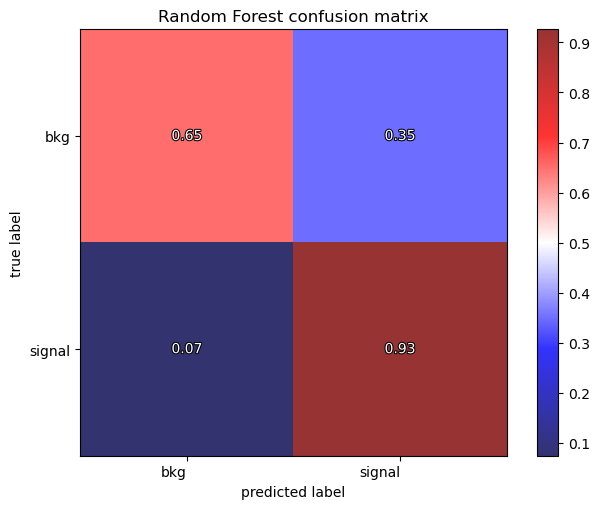

In [423]:
cm = confusion_matrix(Y_test,Y_pred)
RF_cm = normalize_cm(cm)

print('Confusion matrix:')
print(RF_cm)
plot_cm(RF_cm,method_name='Random Forest')


Finally we compute Q and plot the ROC curve

best random forest Q: 1.5697170108821763


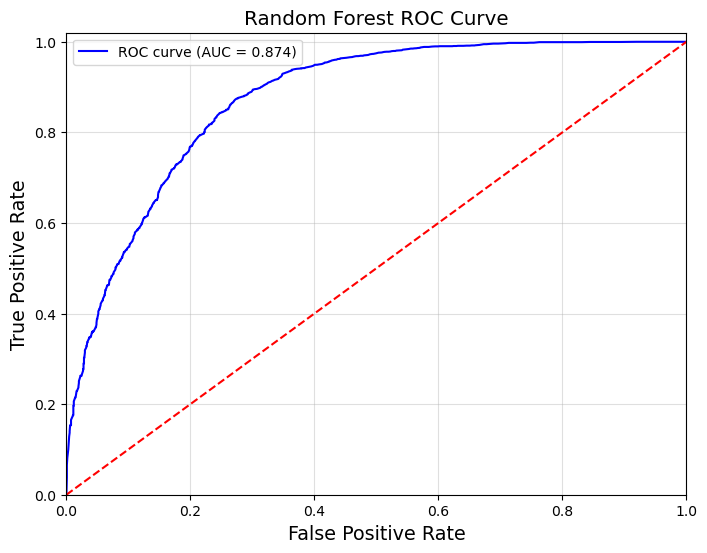

In [424]:
fpr_rforest = fpr
tpr_rforest = tpr
Q_rforest = RF_cm[1][1]/ np.sqrt(RF_cm[0][1])

print('best random forest Q:',Q_rforest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=1.5, label=f'ROC curve (AUC = {roc_auc_best:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Random Forest ROC Curve',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()

## Part 5.5: FFNN
This part is about training a convolluted neural network to fit data. Different parameters are going to be trained in a manual grid search

In [440]:

# redefine NN cycle
hidden_layer_sizes = [(18,), (36,), (54,), (36,18), (54,18), (54,36), (54,36,18)]
learning_rate_init = [ 0.1 , 0.01 , 0.001 ]

start_time = time()

auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict' ) 

parameters = []
fprs = []
tprs = []
aucs = []
partial_aucs = []
hls = []
lrs = []
models = []
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42) 

for size in hidden_layer_sizes:
    for lr in learning_rate_init:
        print(f"Training MLP of size {size} and lr {lr}...")
        lrs.append(lr)
        hls.append(size)
        partial_auc = 0
        auc_value = 0

        for i, (train_index, test_index) in enumerate(kf.split(X)):
            
            print(f" Fold n. {i}")
            train_K=data_rescaled_and_indexed.iloc[train_idx]
            valid_K=data_rescaled_and_indexed.iloc[val_idx]
            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            
            MLP = MLPClassifier(hidden_layer_sizes=size,
                                activation='relu', 
                                max_iter=1000, 
                                alpha=1e-4, 
                                solver='adam', 
                                tol=1e-5, 
                                learning_rate='adaptive',
                                learning_rate_init=lr,
                                verbose=0)
            
            MLP.fit(X_train_K,Y_train_K)
            parameters.append(MLP.coefs_)
            models.append(MLP)
            
            y_pred_proba = MLP.predict_proba(X_valid_K)[:, 1]  
    
            fpr, tpr, _ = roc_curve(Y_valid_K, y_pred_proba)
            fprs.append(fpr)
            tprs.append(tpr)
            auc_value_k = auc(fpr, tpr)
            print("AUC (Test set):", round(auc_value_k,3))
            
            # search for fpr less than 0.2 (if not able fpr is set to zero)
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc = 0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += auc_value_k/K                 
        partial_aucs.append(partial_auc)
        aucs.append(auc_value)
        
        elapsed_time = time() - start_time
        start_time = time()
        print('\n')
        print(f"Time needed for training: {elapsed_time:.2f} seconds")
        print("partial AUC:",round(partial_auc,3)," total AUC:",round(auc_value,3),'\n')


Training MLP of size (18,) and lr 0.1...
 Fold n. 0
AUC (Test set): 0.863
 Fold n. 1
AUC (Test set): 0.845
 Fold n. 2
AUC (Test set): 0.864
 Fold n. 3
AUC (Test set): 0.856
 Fold n. 4
AUC (Test set): 0.861


Time needed for training: 8.05 seconds
partial AUC: 0.095  total AUC: 0.858 

Training MLP of size (18,) and lr 0.01...
 Fold n. 0
AUC (Test set): 0.876
 Fold n. 1
AUC (Test set): 0.872
 Fold n. 2
AUC (Test set): 0.87
 Fold n. 3
AUC (Test set): 0.882
 Fold n. 4
AUC (Test set): 0.878


Time needed for training: 24.64 seconds
partial AUC: 0.104  total AUC: 0.876 

Training MLP of size (18,) and lr 0.001...
 Fold n. 0
AUC (Test set): 0.872
 Fold n. 1
AUC (Test set): 0.871
 Fold n. 2
AUC (Test set): 0.874
 Fold n. 3
AUC (Test set): 0.871
 Fold n. 4
AUC (Test set): 0.871


Time needed for training: 51.14 seconds
partial AUC: 0.103  total AUC: 0.872 

Training MLP of size (36,) and lr 0.1...
 Fold n. 0
AUC (Test set): 0.86
 Fold n. 1
AUC (Test set): 0.865
 Fold n. 2
AUC (Test set): 0.867

Saving the best model's performance and plotting it, as well as the confusion matrix

Confusion matrix:
[[0.591 0.409]
 [0.053 0.947]]


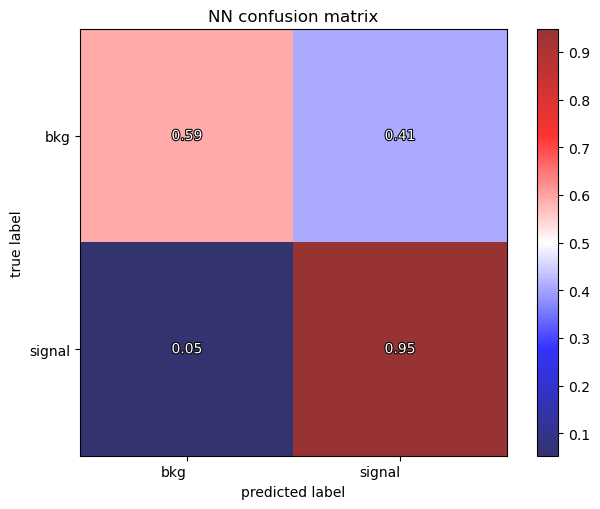

In [441]:
best_index_thresh = np.argmax(np.array(partial_aucs))
best_auc_thresh = aucs[best_index_thresh]
best_fpr_thresh = fprs[best_index_thresh]
best_tpr_thresh = tprs[best_index_thresh]
best_model_NN = models[best_index_thresh]

#print(best_model)
Y_pred = best_model_NN.predict(X_test)
cm = confusion_matrix(Y_test,Y_pred)
NN_cm = normalize_cm(cm)

print('Confusion matrix:')
print(NN_cm)
plot_cm(NN_cm,method_name='NN')


best NN Q value: 1.481
best NN ROC area: 0.87


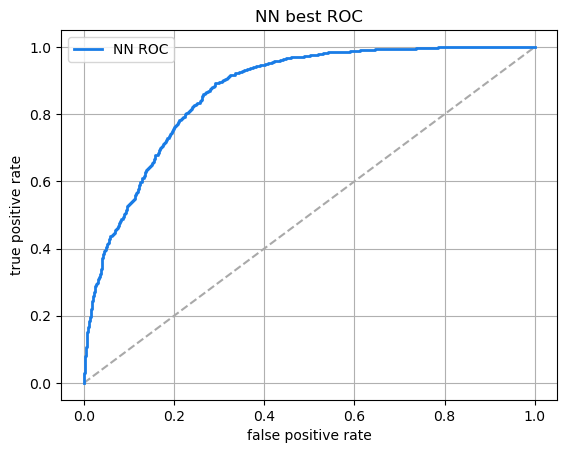

In [445]:
fpr_NN = best_fpr_thresh
tpr_NN = best_tpr_thresh
Q_NN = NN_cm[1][1]/ np.sqrt(NN_cm[0][1])
auc_value = auc(fpr_NN, tpr_NN)

print('best NN Q value:',round(Q_NN,3))
print('best NN ROC area:',round(auc_value,3))

plt.grid()
plt.title('NN best ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='darkgrey')
plt.plot(best_fpr_thresh,best_tpr_thresh,label='NN ROC',lw=2,alpha=1,c='#197ce6')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()


Now we plot them all

best NN Q value: 1.481
best perceptron Q value: 0.96
best SVM Q value: 1.358
best random forest Q value: 1.57
best log_reg Q value: 1.157


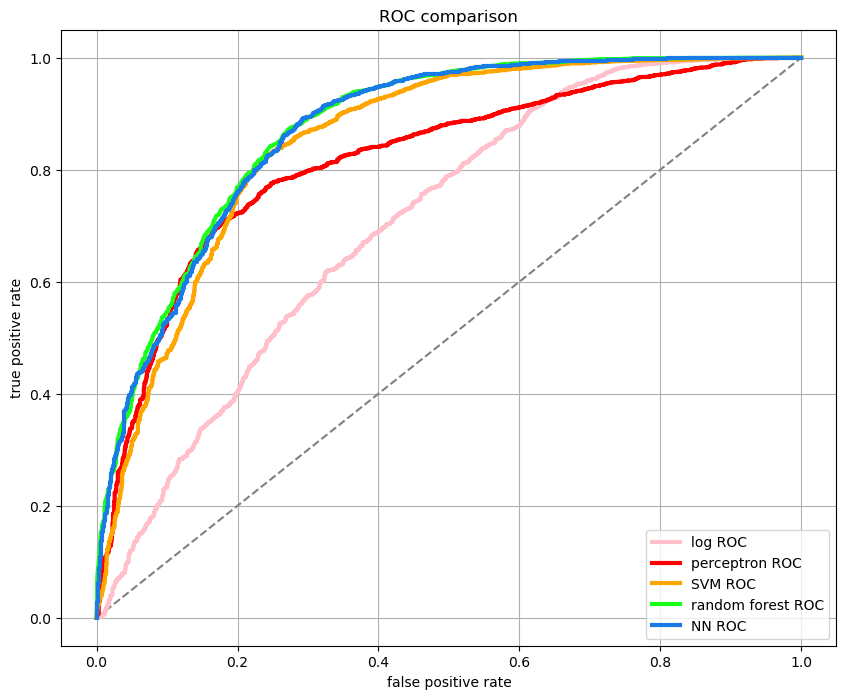

In [462]:
print('best NN Q value:',Q_NN.round(3))
print('best perceptron Q value:',Q_perceptron.round(3))
print('best SVM Q value:',Q_SVM.round(3))
print('best random forest Q value:',Q_rforest.round(3))
print('best log_reg Q value:',Q_log.round(3))

line_width = 3
plt.figure(figsize=(10,8))
plt.grid()
plt.title('ROC comparison',fontsize=24)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr_log,tpr_log,label='log ROC',lw=line_width,alpha=1,c='pink')
plt.plot(fpr_perceptron,tpr_perceptron,label='perceptron ROC',lw=line_width,alpha=1,c='red')
plt.plot(fpr_SVM,tpr_SVM,label='SVM ROC',lw=line_width,alpha=1,c='orange')
plt.plot(fpr_rforest,tpr_rforest,label='random forest ROC',lw=line_width,alpha=1,c='#1aff1a')
plt.plot(fpr_NN,tpr_NN,c='#197ce6',label='NN ROC',lw=line_width,alpha=1)
plt.xlabel('false positive rate',fontsize=18)
plt.ylabel('true positive rate',fontsize=18)
plt.legend(loc=4)
plt.show()

# Part 6: cutting on alpha parameter
In this section a cut on alpha parameter is going to be performed. The best value for alpha is going to be determined, as well as the value that lets only 10% of hadron to be accepted as fp
## NOTE: Alpha param is not rescaled!

In [481]:
X_train['fAlpha'] = train_alpha
X_test['fAlpha'] = test_alpha
print(X_train.columns[:])
print(X_train.shape[:])

Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fDist', 'fAlpha'],
      dtype='object')
(15216, 10)


total gammas: 2463 tot hadrons: 1340 tot test points: 3803
best cut value is Alpha = 0.098 with rate: 0.95
#tp: 19   #fp: 1
rate of saved gammas: 0.0077
 
given threshold rate = 0.9, best cut is: 2.4225 with rate 0.9008
#tp: 436 #fp: 48 rate of saved gammas: 0.177


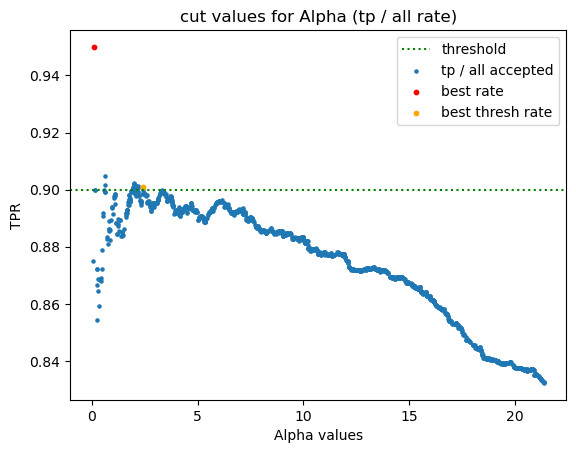

In [482]:
tot_hadrons = len(Y_test[Y_test == -1])
tot_gammas = len(Y_test[Y_test == 1])
tot_hadrons_train = len(Y_train[Y_train == -1])
sel_label = 9
# sel label = Alpha == 9

cut_values = []
rates = []
absolute_tp = []
absolute_fp = []

# setting minimum threshold as 0.90 (editable)
thresh = 0.90

#print('cut value    tp    fp     tp / all')
for i in range(1,tot_hadrons):
    cut_value = find_max_cut_value(X_train,Y_train,sel_label,i)
    
    # to check how the cut value behaves we get the results on test set
    tp, fp = find_tp_fp(X_test,Y_test,sel_label,cut_value)
    if (tp+fp == 0):
        tp = 1
    #print(cut_value,'  ',tp,'  ',fp,'  ',tp/(tp+fp))
    cut_values.append(cut_value)
    rates.append(tp/(tp+fp))
    absolute_tp.append(tp)
    absolute_fp.append(fp)
    
    if (tp/(tp+fp) > thresh):
        best_cut_thresh = cut_value
        rate_thresh = tp/(tp+fp)
        tp_thresh = tp
        fp_thresh = fp

rates = np.array(rates)
mask = np.where(rates < 1,rates,0)
index = np.argmax(mask)
best_rate = rates[index]
best_cut = cut_values[index]
best_tp = absolute_tp[index]
best_fp = absolute_fp[index]

print('total gammas:',tot_gammas,'tot hadrons:',tot_hadrons,'tot test points:',tot_gammas+tot_hadrons)
print('best cut value is Alpha =',round(best_cut,4),'with rate:',round(best_rate,4))
print('#tp:',best_tp,'  #fp:',best_fp)
print('rate of saved gammas:',round(best_tp / tot_gammas,4))
print(' ')
print('given threshold rate = 0.9, best cut is:',round(best_cut_thresh,4),'with rate',round(rate_thresh,4))
print('#tp:',tp_thresh,'#fp:',fp_thresh,'rate of saved gammas:',round(tp_thresh / tot_gammas,4))

plt.axhline(y=0.9, color='g', linestyle=':',label='threshold')  # Dotted green line
plt.scatter(cut_values,rates, s= 5,label='tp / all accepted')
plt.scatter(best_cut,best_rate,c='red',s=10,label='best rate')
plt.scatter(best_cut_thresh,rate_thresh,c='orange',s=10,label='best thresh rate')
plt.legend()
plt.title('cut values for Alpha (tp / all rate)')
plt.xlabel('Alpha values')
plt.ylabel('TPR')
plt.show();



# Part 7: Grid search for best gammaness and alpha cut

In [483]:
print(best_forest)

RandomForestClassifier(max_depth=38, max_features=9, max_samples=1.0,
                       n_estimators=290, n_jobs=-1, random_state=10)


We now apply the best model found in the previous part, i.e: the Random Forest, to look for the combination of parameters *gammaness* and *alpha_cut* that maximizes the quality factor *Q*. What we do is label as background (hadrons) all samples with fAlpha greater than the *alpha_cut* value considered; then we apply the best Random Forest classification to the remaining samples, labelling as gammas only the samples with a predicted probability of belonging to class +1 greater than *gammaness*. Then we determine the TPR and FPR to calculate the correspondent Q value.    
To avoid choosing the best combination of *alpha cut* and *gammaness* solely on the performance on a specific test set, we run the same algorithm on different test sets and choose as best case the one that returns the highest average Q value over the iterations.

In [484]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

file_name="magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']


In [485]:
data_rescaled = data
original_alpha = data['fAlpha'].copy()

for i in data.drop(columns=['category']).columns:
    h = data[i]
    avg = np.mean(h.astype(float))
    std = np.std(h)
    h = h - avg
    h = h / std
    data_rescaled[i]= h
    
print('avg length:',np.average(data_rescaled['fLength']))
print('dev_std length:',np.std(data_rescaled['fLength']))
data_rescaled['fAlpha'] = original_alpha
data_rescaled['category'] = data['category']
data_rescaled['category'] = data_rescaled['category'].replace({'g':1,'h':-1})


avg length: 3.5865241407523854e-17
dev_std length: 0.9999999999999971


In [486]:
N=10
test_predictions=[]
gammaness= np.arange(0.8,0.96,0.01)
alpha_cut= np.arange(2,15,1)

for i in range(1,N+1):
    print('Iteration:',i,'\n')
    
    train_set, test_set = split_train_test_set( data_rescaled, 5)
    X_train, Y_train = split_X_Y(train_set)
    X_test, Y_test = split_X_Y(test_set)
    
    best_forest.fit(X_train,Y_train) 

    for alpha in alpha_cut:
        print('\n')
        for g in gammaness:

            test_data = [ X_test[ X_test['fAlpha']<alpha], Y_test[X_test['fAlpha']<alpha] ] 
            discarded_data = X_test[X_test['fAlpha'] >= alpha]
            discarded_labels = Y_test[X_test['fAlpha'] >= alpha] # we directly classify these points as hadrons 
            
            y_pred_prob = best_forest.predict_proba(test_data[0])[:, 1]
            y_pred_label = np.where(y_pred_prob > g, 1, -1)
        
            selected_gammas= np.sum(y_pred_label==1)
            selected_hadrons= np.sum(y_pred_label==-1) + ( X_test.shape[0]-len(test_data[0])) # samples in alpha cut classified as hadron by the model + all samples previously discarded
    
            total_gammas = np.sum(Y_test==1) # over all the test set (before alpha cut)
            total_hadrons = np.sum(Y_test==-1)
            
            true_positives = np.sum( (y_pred_label==1) & (test_data[1]==1) )
            false_positives = np.sum( (y_pred_label==1) & (test_data[1]==-1) )
            true_negatives= np.sum((y_pred_label == -1) & (test_data[1] == -1)) + np.sum((discarded_labels == -1))
            false_negatives= np.sum((y_pred_label == -1) & (test_data[1] == 1)) + np.sum((discarded_labels == 1))
            
            if false_positives != 0:
                epsilon_gamma = true_positives / total_gammas # TPR
                epsilon_hadron = false_positives / total_hadrons # FPR
                Q = epsilon_gamma/np.sqrt(epsilon_hadron)
            else:
                epsilon_hadron= 0
                epsilon_gamma = true_positives / total_gammas
                Q = 'inf'
                
            test_predictions.append({
            'iteration': i,   
            'alpha_cut': alpha,
            'gamma': g,
            'test_data': test_data, 
            'pred_probs': y_pred_prob,
            'pred label': y_pred_label,
            'selected gammas': selected_gammas,
            'selected hadrons': selected_hadrons,
            'total gammas': total_gammas,
            'total hadrons': total_hadrons,
            'true positives': true_positives,
            'false positives': false_positives,
            'true negatives': true_negatives,
            'false negatives': false_negatives,
            'Q': Q })

            if Q != 'inf':
                print(f"With alpha cut {alpha} and gammaness {g:.2f}, Q = {Q:.4f}")
            else:
                print(f"With alpha cut {alpha} and gammanesss {g:.2f}, Q = {Q}")
            print(f"True positives {true_positives}; False positives {false_positives}")
    

Iteration: 1 



With alpha cut 2 and gammaness 0.80, Q = 1.4078
True positives 341; False positives 13
With alpha cut 2 and gammaness 0.81, Q = 1.4037
True positives 340; False positives 13
With alpha cut 2 and gammaness 0.82, Q = 1.3954
True positives 338; False positives 13
With alpha cut 2 and gammaness 0.83, Q = 1.4395
True positives 335; False positives 12
With alpha cut 2 and gammaness 0.84, Q = 1.5534
True positives 330; False positives 10
With alpha cut 2 and gammaness 0.85, Q = 1.6324
True positives 329; False positives 9
With alpha cut 2 and gammaness 0.86, Q = 1.7104
True positives 325; False positives 8
With alpha cut 2 and gammaness 0.87, Q = 1.6946
True positives 322; False positives 8
With alpha cut 2 and gammaness 0.88, Q = 1.6631
True positives 316; False positives 8
With alpha cut 2 and gammaness 0.89, Q = 1.7329
True positives 308; False positives 7
With alpha cut 2 and gammaness 0.90, Q = 1.8353
True positives 302; False positives 6
With alpha cut 2 and gammaness 0

With alpha cut 7 and gammaness 0.95, Q = 2.5367
True positives 660; False positives 15


With alpha cut 8 and gammaness 0.80, Q = 2.4814
True positives 1014; False positives 37
With alpha cut 8 and gammaness 0.81, Q = 2.5337
True positives 1007; False positives 35
With alpha cut 8 and gammaness 0.82, Q = 2.5086
True positives 997; False positives 35
With alpha cut 8 and gammaness 0.83, Q = 2.5171
True positives 986; False positives 34
With alpha cut 8 and gammaness 0.84, Q = 2.5630
True positives 974; False positives 32
With alpha cut 8 and gammaness 0.85, Q = 2.6757
True positives 968; False positives 29
With alpha cut 8 and gammaness 0.86, Q = 2.6865
True positives 955; False positives 28
With alpha cut 8 and gammaness 0.87, Q = 2.6986
True positives 942; False positives 27
With alpha cut 8 and gammaness 0.88, Q = 2.6441
True positives 923; False positives 27
With alpha cut 8 and gammaness 0.89, Q = 2.6244
True positives 899; False positives 26
With alpha cut 8 and gammaness 0.90, Q 

With alpha cut 13 and gammaness 0.92, Q = 2.8872
True positives 989; False positives 26
With alpha cut 13 and gammaness 0.93, Q = 2.8104
True positives 944; False positives 25
With alpha cut 13 and gammaness 0.94, Q = 2.7610
True positives 870; False positives 22
With alpha cut 13 and gammaness 0.95, Q = 2.7559
True positives 807; False positives 19


With alpha cut 14 and gammaness 0.80, Q = 2.4519
True positives 1297; False positives 62
With alpha cut 14 and gammaness 0.81, Q = 2.4922
True positives 1286; False positives 59
With alpha cut 14 and gammaness 0.82, Q = 2.4823
True positives 1270; False positives 58
With alpha cut 14 and gammaness 0.83, Q = 2.4744
True positives 1255; False positives 57
With alpha cut 14 and gammaness 0.84, Q = 2.5272
True positives 1236; False positives 53
With alpha cut 14 and gammaness 0.85, Q = 2.5704
True positives 1221; False positives 50
With alpha cut 14 and gammaness 0.86, Q = 2.5783
True positives 1200; False positives 48
With alpha cut 14 and g

With alpha cut 6 and gammaness 0.90, Q = 2.5015
True positives 754; False positives 19
With alpha cut 6 and gammaness 0.91, Q = 2.5990
True positives 741; False positives 17
With alpha cut 6 and gammaness 0.92, Q = 2.5995
True positives 719; False positives 16
With alpha cut 6 and gammaness 0.93, Q = 2.7394
True positives 683; False positives 13
With alpha cut 6 and gammaness 0.94, Q = 2.6271
True positives 655; False positives 13
With alpha cut 6 and gammaness 0.95, Q = 2.5841
True positives 619; False positives 12


With alpha cut 7 and gammaness 0.80, Q = 2.1536
True positives 918; False positives 38
With alpha cut 7 and gammaness 0.81, Q = 2.1419
True positives 913; False positives 38
With alpha cut 7 and gammaness 0.82, Q = 2.1325
True positives 909; False positives 38
With alpha cut 7 and gammaness 0.83, Q = 2.1207
True positives 904; False positives 38
With alpha cut 7 and gammaness 0.84, Q = 2.1112
True positives 888; False positives 37
With alpha cut 7 and gammaness 0.85, Q = 

With alpha cut 12 and gammaness 0.89, Q = 2.6919
True positives 1053; False positives 32
With alpha cut 12 and gammaness 0.90, Q = 2.7472
True positives 1023; False positives 29
With alpha cut 12 and gammaness 0.91, Q = 2.7636
True positives 993; False positives 27
With alpha cut 12 and gammaness 0.92, Q = 2.7198
True positives 959; False positives 26
With alpha cut 12 and gammaness 0.93, Q = 2.8119
True positives 912; False positives 22
With alpha cut 12 and gammaness 0.94, Q = 2.7171
True positives 861; False positives 21
With alpha cut 12 and gammaness 0.95, Q = 2.6376
True positives 795; False positives 19


With alpha cut 13 and gammaness 0.80, Q = 2.4258
True positives 1244; False positives 55
With alpha cut 13 and gammaness 0.81, Q = 2.4285
True positives 1234; False positives 54
With alpha cut 13 and gammaness 0.82, Q = 2.4294
True positives 1223; False positives 53
With alpha cut 13 and gammaness 0.83, Q = 2.3996
True positives 1208; False positives 53
With alpha cut 13 and ga

With alpha cut 5 and gammaness 0.87, Q = 2.8296
True positives 703; False positives 14
With alpha cut 5 and gammaness 0.88, Q = 2.8738
True positives 688; False positives 13
With alpha cut 5 and gammaness 0.89, Q = 2.8195
True positives 675; False positives 13
With alpha cut 5 and gammaness 0.90, Q = 2.7443
True positives 657; False positives 13
With alpha cut 5 and gammaness 0.91, Q = 2.7911
True positives 642; False positives 12
With alpha cut 5 and gammaness 0.92, Q = 2.9480
True positives 619; False positives 10
With alpha cut 5 and gammaness 0.93, Q = 3.0221
True positives 602; False positives 9
With alpha cut 5 and gammaness 0.94, Q = 2.8514
True positives 568; False positives 9
With alpha cut 5 and gammaness 0.95, Q = 3.0966
True positives 544; False positives 7


With alpha cut 6 and gammaness 0.80, Q = 2.6347
True positives 839; False positives 23
With alpha cut 6 and gammaness 0.81, Q = 2.6347
True positives 839; False positives 23
With alpha cut 6 and gammaness 0.82, Q = 2.6

With alpha cut 11 and gammaness 0.86, Q = 2.9179
True positives 1113; False positives 33
With alpha cut 11 and gammaness 0.87, Q = 2.9099
True positives 1093; False positives 32
With alpha cut 11 and gammaness 0.88, Q = 2.8780
True positives 1064; False positives 31
With alpha cut 11 and gammaness 0.89, Q = 2.8131
True positives 1040; False positives 31
With alpha cut 11 and gammaness 0.90, Q = 2.7401
True positives 1013; False positives 31
With alpha cut 11 and gammaness 0.91, Q = 2.7631
True positives 988; False positives 29
With alpha cut 11 and gammaness 0.92, Q = 2.8584
True positives 949; False positives 25
With alpha cut 11 and gammaness 0.93, Q = 2.9347
True positives 914; False positives 22
With alpha cut 11 and gammaness 0.94, Q = 2.7228
True positives 848; False positives 22
With alpha cut 11 and gammaness 0.95, Q = 2.9477
True positives 807; False positives 17


With alpha cut 12 and gammaness 0.80, Q = 2.6691
True positives 1215; False positives 47
With alpha cut 12 and ga

With alpha cut 4 and gammaness 0.84, Q = 1.7701
True positives 620; False positives 28
With alpha cut 4 and gammaness 0.85, Q = 1.7558
True positives 615; False positives 28
With alpha cut 4 and gammaness 0.86, Q = 1.7735
True positives 610; False positives 27
With alpha cut 4 and gammaness 0.87, Q = 1.7648
True positives 607; False positives 27
With alpha cut 4 and gammaness 0.88, Q = 1.7502
True positives 602; False positives 27
With alpha cut 4 and gammaness 0.89, Q = 1.7947
True positives 594; False positives 25
With alpha cut 4 and gammaness 0.90, Q = 1.8040
True positives 585; False positives 24
With alpha cut 4 and gammaness 0.91, Q = 1.8050
True positives 573; False positives 23
With alpha cut 4 and gammaness 0.92, Q = 1.8714
True positives 554; False positives 20
With alpha cut 4 and gammaness 0.93, Q = 1.9121
True positives 537; False positives 18
With alpha cut 4 and gammaness 0.94, Q = 1.9375
True positives 513; False positives 16
With alpha cut 4 and gammaness 0.95, Q = 2.

With alpha cut 10 and gammaness 0.82, Q = 2.3781
True positives 1146; False positives 53
With alpha cut 10 and gammaness 0.83, Q = 2.3677
True positives 1141; False positives 53
With alpha cut 10 and gammaness 0.84, Q = 2.3778
True positives 1135; False positives 52
With alpha cut 10 and gammaness 0.85, Q = 2.3756
True positives 1123; False positives 51
With alpha cut 10 and gammaness 0.86, Q = 2.3736
True positives 1111; False positives 50
With alpha cut 10 and gammaness 0.87, Q = 2.3761
True positives 1101; False positives 49
With alpha cut 10 and gammaness 0.88, Q = 2.4547
True positives 1090; False positives 45
With alpha cut 10 and gammaness 0.89, Q = 2.5221
True positives 1069; False positives 41
With alpha cut 10 and gammaness 0.90, Q = 2.5376
True positives 1049; False positives 39
With alpha cut 10 and gammaness 0.91, Q = 2.5432
True positives 1024; False positives 37
With alpha cut 10 and gammaness 0.92, Q = 2.5693
True positives 977; False positives 33
With alpha cut 10 and 

With alpha cut 3 and gammaness 0.80, Q = 1.5755
True positives 498; False positives 22
With alpha cut 3 and gammaness 0.81, Q = 1.6061
True positives 496; False positives 21
With alpha cut 3 and gammaness 0.82, Q = 1.6325
True positives 492; False positives 20
With alpha cut 3 and gammaness 0.83, Q = 1.6579
True positives 487; False positives 19
With alpha cut 3 and gammaness 0.84, Q = 1.6754
True positives 479; False positives 18
With alpha cut 3 and gammaness 0.85, Q = 1.7167
True positives 477; False positives 17
With alpha cut 3 and gammaness 0.86, Q = 1.7547
True positives 473; False positives 16
With alpha cut 3 and gammaness 0.87, Q = 1.8085
True positives 472; False positives 15
With alpha cut 3 and gammaness 0.88, Q = 1.7855
True positives 466; False positives 15
With alpha cut 3 and gammaness 0.89, Q = 1.8243
True positives 460; False positives 14
With alpha cut 3 and gammaness 0.90, Q = 1.9619
True positives 458; False positives 12
With alpha cut 3 and gammaness 0.91, Q = 2.

With alpha cut 9 and gammaness 0.80, Q = 2.2513
True positives 1094; False positives 52
With alpha cut 9 and gammaness 0.81, Q = 2.2587
True positives 1087; False positives 51
With alpha cut 9 and gammaness 0.82, Q = 2.2895
True positives 1080; False positives 49
With alpha cut 9 and gammaness 0.83, Q = 2.3389
True positives 1069; False positives 46
With alpha cut 9 and gammaness 0.84, Q = 2.3338
True positives 1055; False positives 45
With alpha cut 9 and gammaness 0.85, Q = 2.3467
True positives 1049; False positives 44
With alpha cut 9 and gammaness 0.86, Q = 2.3444
True positives 1036; False positives 43
With alpha cut 9 and gammaness 0.87, Q = 2.3638
True positives 1020; False positives 41
With alpha cut 9 and gammaness 0.88, Q = 2.3833
True positives 1003; False positives 39
With alpha cut 9 and gammaness 0.89, Q = 2.4103
True positives 988; False positives 37
With alpha cut 9 and gammaness 0.90, Q = 2.5524
True positives 973; False positives 32
With alpha cut 9 and gammaness 0.9

With alpha cut 14 and gammaness 0.94, Q = 2.6068
True positives 946; False positives 29
With alpha cut 14 and gammaness 0.95, Q = 2.7588
True positives 872; False positives 22
Iteration: 6 



With alpha cut 2 and gammaness 0.80, Q = 1.8144
True positives 348; False positives 8
With alpha cut 2 and gammaness 0.81, Q = 1.8040
True positives 346; False positives 8
With alpha cut 2 and gammaness 0.82, Q = 1.9007
True positives 341; False positives 7
With alpha cut 2 and gammaness 0.83, Q = 2.0409
True positives 339; False positives 6
With alpha cut 2 and gammaness 0.84, Q = 2.4922
True positives 338; False positives 4
With alpha cut 2 and gammaness 0.85, Q = 2.4627
True positives 334; False positives 4
With alpha cut 2 and gammaness 0.86, Q = 2.4406
True positives 331; False positives 4
With alpha cut 2 and gammaness 0.87, Q = 2.4038
True positives 326; False positives 4
With alpha cut 2 and gammaness 0.88, Q = 2.3743
True positives 322; False positives 4
With alpha cut 2 and gammaness 0.

With alpha cut 7 and gammaness 0.94, Q = 2.9165
True positives 740; False positives 14
With alpha cut 7 and gammaness 0.95, Q = 2.7471
True positives 697; False positives 14


With alpha cut 8 and gammaness 0.80, Q = 2.1293
True positives 1021; False positives 50
With alpha cut 8 and gammaness 0.81, Q = 2.1404
True positives 1016; False positives 49
With alpha cut 8 and gammaness 0.82, Q = 2.2365
True positives 1006; False positives 44
With alpha cut 8 and gammaness 0.83, Q = 2.2664
True positives 996; False positives 42
With alpha cut 8 and gammaness 0.84, Q = 2.3401
True positives 991; False positives 39
With alpha cut 8 and gammaness 0.85, Q = 2.4087
True positives 980; False positives 36
With alpha cut 8 and gammaness 0.86, Q = 2.3767
True positives 967; False positives 36
With alpha cut 8 and gammaness 0.87, Q = 2.3497
True positives 956; False positives 36
With alpha cut 8 and gammaness 0.88, Q = 2.3431
True positives 940; False positives 35
With alpha cut 8 and gammaness 0.89, Q

With alpha cut 13 and gammaness 0.91, Q = 2.4423
True positives 1086; False positives 43
With alpha cut 13 and gammaness 0.92, Q = 2.5432
True positives 1049; False positives 37
With alpha cut 13 and gammaness 0.93, Q = 2.6056
True positives 1015; False positives 33
With alpha cut 13 and gammaness 0.94, Q = 2.5659
True positives 953; False positives 30
With alpha cut 13 and gammaness 0.95, Q = 2.4692
True positives 886; False positives 28


With alpha cut 14 and gammaness 0.80, Q = 2.2110
True positives 1341; False positives 80
With alpha cut 14 and gammaness 0.81, Q = 2.2117
True positives 1333; False positives 79
With alpha cut 14 and gammaness 0.82, Q = 2.2594
True positives 1318; False positives 74
With alpha cut 14 and gammaness 0.83, Q = 2.2878
True positives 1298; False positives 70
With alpha cut 14 and gammaness 0.84, Q = 2.3949
True positives 1289; False positives 63
With alpha cut 14 and gammaness 0.85, Q = 2.4421
True positives 1272; False positives 59
With alpha cut 14 and

With alpha cut 6 and gammaness 0.90, Q = 2.9737
True positives 744; False positives 14
With alpha cut 6 and gammaness 0.91, Q = 3.1170
True positives 722; False positives 12
With alpha cut 6 and gammaness 0.92, Q = 3.0350
True positives 703; False positives 12
With alpha cut 6 and gammaness 0.93, Q = 3.0572
True positives 678; False positives 11
With alpha cut 6 and gammaness 0.94, Q = 3.4580
True positives 654; False positives 8
With alpha cut 6 and gammaness 0.95, Q = 3.2835
True positives 621; False positives 8


With alpha cut 7 and gammaness 0.80, Q = 2.6047
True positives 905; False positives 27
With alpha cut 7 and gammaness 0.81, Q = 2.5961
True positives 902; False positives 27
With alpha cut 7 and gammaness 0.82, Q = 2.6279
True positives 896; False positives 26
With alpha cut 7 and gammaness 0.83, Q = 2.7139
True positives 889; False positives 24
With alpha cut 7 and gammaness 0.84, Q = 2.6833
True positives 879; False positives 24
With alpha cut 7 and gammaness 0.85, Q = 2.

With alpha cut 12 and gammaness 0.89, Q = 3.3429
True positives 1072; False positives 23
With alpha cut 12 and gammaness 0.90, Q = 3.3160
True positives 1040; False positives 22
With alpha cut 12 and gammaness 0.91, Q = 3.3541
True positives 1003; False positives 20
With alpha cut 12 and gammaness 0.92, Q = 3.3910
True positives 962; False positives 18
With alpha cut 12 and gammaness 0.93, Q = 3.6492
True positives 913; False positives 14
With alpha cut 12 and gammaness 0.94, Q = 3.9320
True positives 872; False positives 11
With alpha cut 12 and gammaness 0.95, Q = 3.6299
True positives 805; False positives 11


With alpha cut 13 and gammaness 0.80, Q = 2.8002
True positives 1242; False positives 44
With alpha cut 13 and gammaness 0.81, Q = 2.8098
True positives 1232; False positives 43
With alpha cut 13 and gammaness 0.82, Q = 2.8199
True positives 1222; False positives 42
With alpha cut 13 and gammaness 0.83, Q = 2.9749
True positives 1210; False positives 37
With alpha cut 13 and g

With alpha cut 5 and gammaness 0.87, Q = 2.2524
True positives 696; False positives 20
With alpha cut 5 and gammaness 0.88, Q = 2.2362
True positives 691; False positives 20
With alpha cut 5 and gammaness 0.89, Q = 2.1942
True positives 678; False positives 20
With alpha cut 5 and gammaness 0.90, Q = 2.3448
True positives 668; False positives 17
With alpha cut 5 and gammaness 0.91, Q = 2.3735
True positives 656; False positives 16
With alpha cut 5 and gammaness 0.92, Q = 2.5369
True positives 632; False positives 13
With alpha cut 5 and gammaness 0.93, Q = 2.4606
True positives 613; False positives 13
With alpha cut 5 and gammaness 0.94, Q = 2.5877
True positives 593; False positives 11
With alpha cut 5 and gammaness 0.95, Q = 2.6179
True positives 572; False positives 10


With alpha cut 6 and gammaness 0.80, Q = 2.1289
True positives 845; False positives 33
With alpha cut 6 and gammaness 0.81, Q = 2.1887
True positives 842; False positives 31
With alpha cut 6 and gammaness 0.82, Q = 

With alpha cut 11 and gammaness 0.85, Q = 2.5202
True positives 1115; False positives 41
With alpha cut 11 and gammaness 0.86, Q = 2.5661
True positives 1093; False positives 38
With alpha cut 11 and gammaness 0.87, Q = 2.7008
True positives 1072; False positives 33
With alpha cut 11 and gammaness 0.88, Q = 2.7450
True positives 1056; False positives 31
With alpha cut 11 and gammaness 0.89, Q = 2.7789
True positives 1034; False positives 29
With alpha cut 11 and gammaness 0.90, Q = 2.8809
True positives 1015; False positives 26
With alpha cut 11 and gammaness 0.91, Q = 2.9277
True positives 991; False positives 24
With alpha cut 11 and gammaness 0.92, Q = 3.0224
True positives 957; False positives 21
With alpha cut 11 and gammaness 0.93, Q = 2.9514
True positives 912; False positives 20
With alpha cut 11 and gammaness 0.94, Q = 3.0503
True positives 869; False positives 17
With alpha cut 11 and gammaness 0.95, Q = 3.0792
True positives 824; False positives 15


With alpha cut 12 and ga

With alpha cut 4 and gammaness 0.82, Q = 2.1402
True positives 622; False positives 18
With alpha cut 4 and gammaness 0.83, Q = 2.1264
True positives 618; False positives 18
With alpha cut 4 and gammaness 0.84, Q = 2.1092
True positives 613; False positives 18
With alpha cut 4 and gammaness 0.85, Q = 2.0782
True positives 604; False positives 18
With alpha cut 4 and gammaness 0.86, Q = 2.0679
True positives 601; False positives 18
With alpha cut 4 and gammaness 0.87, Q = 2.1678
True positives 594; False positives 16
With alpha cut 4 and gammaness 0.88, Q = 2.1974
True positives 583; False positives 15
With alpha cut 4 and gammaness 0.89, Q = 2.2394
True positives 574; False positives 14
With alpha cut 4 and gammaness 0.90, Q = 2.1965
True positives 563; False positives 14
With alpha cut 4 and gammaness 0.91, Q = 2.2471
True positives 555; False positives 13
With alpha cut 4 and gammaness 0.92, Q = 2.2672
True positives 538; False positives 12
With alpha cut 4 and gammaness 0.93, Q = 2.

With alpha cut 10 and gammaness 0.81, Q = 2.2804
True positives 1169; False positives 56
With alpha cut 10 and gammaness 0.82, Q = 2.3260
True positives 1160; False positives 53
With alpha cut 10 and gammaness 0.83, Q = 2.3361
True positives 1154; False positives 52
With alpha cut 10 and gammaness 0.84, Q = 2.3364
True positives 1143; False positives 51
With alpha cut 10 and gammaness 0.85, Q = 2.3683
True positives 1124; False positives 48
With alpha cut 10 and gammaness 0.86, Q = 2.3763
True positives 1116; False positives 47
With alpha cut 10 and gammaness 0.87, Q = 2.4510
True positives 1101; False positives 43
With alpha cut 10 and gammaness 0.88, Q = 2.5222
True positives 1079; False positives 39
With alpha cut 10 and gammaness 0.89, Q = 2.5391
True positives 1058; False positives 37
With alpha cut 10 and gammaness 0.90, Q = 2.5736
True positives 1028; False positives 34
With alpha cut 10 and gammaness 0.91, Q = 2.6481
True positives 1010; False positives 31
With alpha cut 10 and

With alpha cut 2 and gammaness 0.95, Q = 2.4098
True positives 234; False positives 2


With alpha cut 3 and gammaness 0.80, Q = 1.6894
True positives 464; False positives 16
With alpha cut 3 and gammaness 0.81, Q = 1.6821
True positives 462; False positives 16
With alpha cut 3 and gammaness 0.82, Q = 1.7260
True positives 459; False positives 15
With alpha cut 3 and gammaness 0.83, Q = 1.7710
True positives 455; False positives 14
With alpha cut 3 and gammaness 0.84, Q = 1.9045
True positives 453; False positives 12
With alpha cut 3 and gammaness 0.85, Q = 1.9716
True positives 449; False positives 11
With alpha cut 3 and gammaness 0.86, Q = 1.9497
True positives 444; False positives 11
With alpha cut 3 and gammaness 0.87, Q = 1.9365
True positives 441; False positives 11
With alpha cut 3 and gammaness 0.88, Q = 1.8882
True positives 430; False positives 11
With alpha cut 3 and gammaness 0.89, Q = 1.8574
True positives 423; False positives 11
With alpha cut 3 and gammaness 0.90, Q = 1

With alpha cut 8 and gammaness 0.95, Q = 2.5750
True positives 729; False positives 17


With alpha cut 9 and gammaness 0.80, Q = 2.2059
True positives 1071; False positives 50
With alpha cut 9 and gammaness 0.81, Q = 2.1956
True positives 1066; False positives 50
With alpha cut 9 and gammaness 0.82, Q = 2.2033
True positives 1059; False positives 49
With alpha cut 9 and gammaness 0.83, Q = 2.2525
True positives 1049; False positives 46
With alpha cut 9 and gammaness 0.84, Q = 2.2922
True positives 1044; False positives 44
With alpha cut 9 and gammaness 0.85, Q = 2.3191
True positives 1032; False positives 42
With alpha cut 9 and gammaness 0.86, Q = 2.3373
True positives 1015; False positives 40
With alpha cut 9 and gammaness 0.87, Q = 2.3437
True positives 1005; False positives 39
With alpha cut 9 and gammaness 0.88, Q = 2.3318
True positives 987; False positives 38
With alpha cut 9 and gammaness 0.89, Q = 2.3805
True positives 967; False positives 35
With alpha cut 9 and gammaness 0.

With alpha cut 14 and gammaness 0.93, Q = 2.7303
True positives 992; False positives 28
With alpha cut 14 and gammaness 0.94, Q = 2.8667
True positives 944; False positives 23
With alpha cut 14 and gammaness 0.95, Q = 2.7490
True positives 865; False positives 21


To handle the very few cases that return 0 false positives and thus an "infinite" Q value, we decide to consider the median of the Q values across the different iterations instead of the average. To estimate the standard deviation of the values found we ignore these cases.     

In [487]:
test_predictions_df = pd.DataFrame(test_predictions)
test_predictions_df['Q'] = test_predictions_df['Q'].replace('inf', 1e20) # assign very high value to Q to find median
test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median_Q = 'median',
    std= lambda x: np.std(x[x != 1e20])).reset_index()

,alpha_cut,gamma,median_Q,std
0,2,0.80,1.636112,0.314715
1,2,0.81,1.681152,0.304126
2,2,0.82,1.729169,0.303036
3,2,0.83,1.710345,0.300811
4,2,0.84,1.786641,0.373921
...,...,...,...,...
203,14,0.91,2.736572,0.246648
204,14,0.92,2.717327,0.253454
205,14,0.93,2.766283,0.284368
206,14,0.94,2.750368,0.416959


In [488]:
grouped_pred = test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median= 'median',
    std= lambda x: np.std(x[x != 1e20]) ).reset_index()

max_mean_row = grouped_pred.loc[grouped_pred['median'].idxmax()]

max_mean = max_mean_row['median']
std_dev = max_mean_row['std']

print(f"The best average Q value found is {max_mean:.2f} ± {std_dev/(N)**0.5:.2f}")
print(f"The best Alpha cut found is {max_mean_row['alpha_cut']:.0f}° ")
print(f"The best gammaness found is {max_mean_row['gamma']:.2f}")

The best average Q value found is 2.89 ± 0.09
The best Alpha cut found is 10° 
The best gammaness found is 0.95


In [489]:
selected = test_predictions_df[
    (test_predictions_df['gamma'] == max_mean_row['gamma']) & 
    (test_predictions_df['alpha_cut'] == max_mean_row['alpha_cut'])]

selected_gammas = selected['selected gammas']/selected['total gammas']
avg_selected_gammas= selected_gammas.mean()
std_selected_gammas= selected_gammas.std()
print(f"With these best parameters, the average fraction of selected gammas is ({avg_selected_gammas*100:.2f} ± {std_selected_gammas*100/(N)**0.5:.2f})%")

With these best parameters, the average fraction of selected gammas is (32.90 ± 0.41)%


This means that, applying this technique on the given dataset with $N_{\gamma} = 12332$ true gamma events, we would identify $n_{\gamma} = (4199 ± 1)$ events as gamma, disregarding the remaining as backgorund. In particular we have the following average performance for the algorithm in terms of TPR, FPR, TNR, FNR:

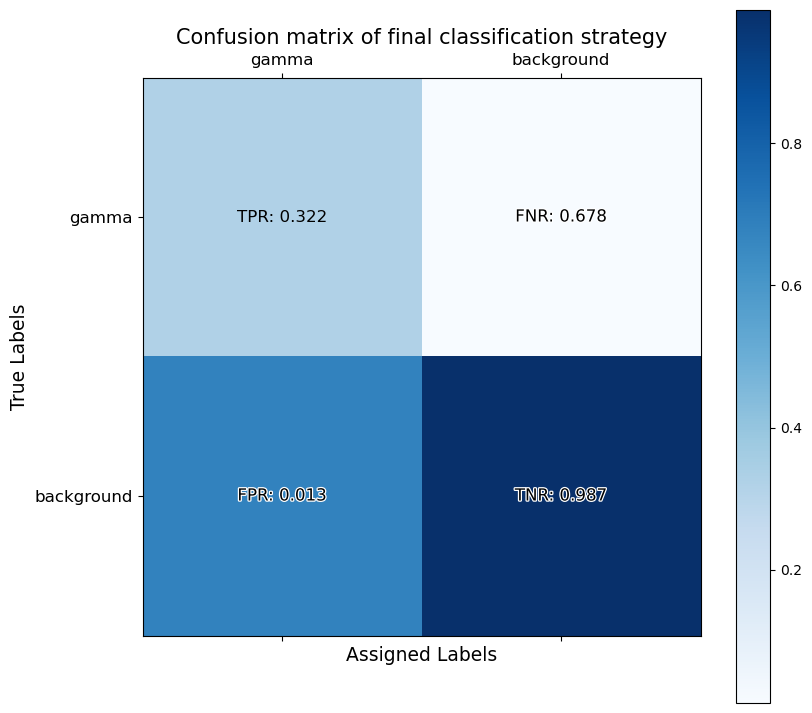

In [490]:

tpr = selected['true positives']/selected['total gammas']
tpr_avg = tpr.mean()

fpr = selected['false positives']/selected['total hadrons']
fpr_avg = fpr.mean()

tnr = selected['true negatives']/selected['total hadrons']
tnr_avg= tnr.mean()

fnr = selected['false negatives']/selected['total gammas']
fnr_avg= fnr.mean()

confusion_matrix = np.array([[tpr_avg, fpr_avg], [fnr_avg, tnr_avg]])

fig, ax = plt.subplots(figsize=(9, 9))
cax = ax.matshow(confusion_matrix, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_xticklabels(['gamma', 'background'],fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['gamma', 'background'],fontsize=12)

path_effects_white = [path_effects.withStroke(linewidth=1.8, foreground='white')]

# Adding text with white contour
text_params = {'ha': 'center', 'va': 'center', 'color': 'black', 'fontsize': 12, 'path_effects': path_effects_white}


ax.text(0, 0, f'TPR: {tpr_avg:.3f}', ha='center', va='center', color='black',fontsize=12)
ax.text(1, 0, f'FNR: {fnr_avg:.3f}', **text_params)
ax.text(0, 1, f'FPR: {fpr_avg:.3f}', **text_params)
ax.text(1, 1, f'TNR: {tnr_avg:.3f}', **text_params)

fig.colorbar(cax)

ax.set_title('Confusion matrix of final classification strategy',fontsize=15)
ax.set_xlabel('Assigned Labels',fontsize=13.5)
ax.set_ylabel('True Labels',fontsize=13.5)

plt.show()

# Part 8: Calculation of the observation time

Assuming that the telescope has a collection area of 10^9 cm^2 and that we are observing gamma rays between 50 GeV and 50 TeV, to what observation time does this measurement corresponds? (assume here the Crab spectrum measured by HEGRA [Aharonian, F. et al. 2000])

------da rivedere descrizione-------
- da capire +- 0.5
- da capire se vogliamo dividere il range 0.05 Tev - 50 Tev in due e usare il primo integrale per 1-50 e il secondo (log) per 0.05-1 (al momento non sono divisi)

To calculate the observation time corresponding to the Cherenkov telescope measurement, we use the Crab Nebula spectrum measured by HEGRA. Then, converting the telescope's collection area to square meters ( $A = 10^9 \, \text{cm}^2 = 10^5 \, \text{m}^2 $), we can determine
the event rate by integrating the flux over the energy range from **50 GeV to 50 TeV**:

$$
R = A \cdot J_{\gamma} =  A \int_{0.05 \, TeV}^{50 \, TeV} \frac{dJ_{\gamma}}{dE} dE
$$

This integration provides the **event rate in photons per second**. Given the total number of recorded events $n_\gamma$, we can then calculate the **observation time** by dividing the number of events by the event rate:

$$
\Delta t = \frac{n_{\gamma}}{R}
$$

In [491]:
# Constants
A = 10**9 * 1e-4  # collection area in m^2
E0 = 1.0  # TeV
Emin = 0.05  # TeV = 50 GeV
Emax = 50  # TeV
n_gamma, sigma_n_gamma = 4000, 200 #--------------------------------------insert our value here---------------------------

# Constants for the first integral
alpha1, alpha1_err = 2.59, 0.03
c1, c1_err = 2.79e-7, 0.02e-7

# Constants for the second integral
c2, c2_err = 2.67e-7, 0.01e-7
alpha2, alpha2_err = 2.47, 0.1
beta, beta_err = 0.11, 0.1

Primo integrale con errore dato da derivate parziali

# First integral
According to the study by **Aharonian et al. (2000)**, the differential flux of gamma rays in the range of $1-20 \, \text{TeV}$ is given by:

$$
\frac{dJ_{\gamma}}{dE} = (2.79 \pm 0.02) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.59 \pm 0.03)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
\frac{dJ_{\gamma}}{dE} = c_1 \cdot \left( \frac{E}{E_0} \right)^{- \alpha_1} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with:
$$
c_1 = (2.79 \pm 0.02) \times 10^{-7}, E_0 = 1 \, \text{TeV}, \alpha_1 = 2.59 \pm 0.03
$$
so the integral will be:
$$
J_\gamma = \frac{E_0^{\alpha_1} \cdot c_1}{-\alpha_1 + 1} \cdot \left( E_{\text{max}}^{-\alpha_1 + 1} - E_{\text{min}}^{-\alpha_1 + 1} \right)
$$
with $E_{\text{min}} = 0.05 \, \text{TeV}, E_{\text{max}} = 50 \, \text{TeV} $

### Error Propagation

We have uncertainties in the following parameters:

$$
c_1 = (2.79 \pm 0.02) \times 10^{-7}
$$
$$
\alpha_1 = 2.59 \pm 0.03
$$

Using the general error propagation formula the total uncertainty in R:

$$
\sigma_R = \sqrt{ \left( \frac{\partial R}{\partial c_1} \sigma_{c_1} \right)^2 + \left( \frac{\partial R}{\partial \alpha_1} \sigma_{\alpha_1} \right)^2 }
$$

The error for the time will be:
$$
\sigma_t = t \sqrt{ \left( \frac{\sigma_{n_{\gamma}}}{n_{\gamma}} \right)^2 + \left( \frac{\sigma_R}{R} \right)^2 }
$$

In [492]:
import sympy as sp

def uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err):
    #definisco i simboli
    c1_sym, alpha1_sym, Emin_sym, Emax_sym, E0_sym, A_sym = sp.symbols('c1 alpha1 Emin Emax E0 A')
    
    #definizione di R 
    R = (A_sym * c1_sym * (E0_sym**alpha1_sym) / (-alpha1_sym + 1)) * (Emax_sym**(-alpha1_sym + 1) - Emin_sym**(-alpha1_sym + 1))

    #calcolo le derivate parziali rispetto a c1 e alpha1
    dR_dc1 = sp.diff(R, c1_sym)
    dR_dalpha1 = sp.diff(R, alpha1_sym)
    
    #conversione a funzioni
    dR_dc1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dc1, 'numpy')
    dR_dalpha1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dalpha1, 'numpy')
    
    #calcolo il valore delle derivate e di R
    dR_dc1_val = dR_dc1_func(A, E0, Emin, Emax, c1, alpha1)
    dR_dalpha1_val = dR_dalpha1_func(A, E0, Emin, Emax, c1, alpha1)
    R_val = (A * c1 * (E0**alpha1) / (-alpha1 + 1)) * (Emax**(-alpha1 + 1) - Emin**(-alpha1 + 1))
    
    #incertezza totale su R
    sigma_R = np.sqrt((dR_dc1_val * c1_err) ** 2 + (dR_dalpha1_val * alpha1_err) ** 2)
    
    return R_val, sigma_R


#valore dell'errore su R
R_val, sigma_R = uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err)

t1 = (n_gamma / R_val) / 60
sigma_t1 = t1 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R_val)**2)) / 60

print(f"t1 = {t1:.2f} ± {sigma_t1:.2f} minutes")

t1 = 32.44 ± 0.05 minutes


## Second integral
At low energies there is a slight flattening of the spectrum. A fit with a logarithmic steepening of the power law spectrum gives (according to the study by **Aharonian et al. (2000)**):
$$
\frac{dJ_{\gamma}}{dE} = (2.67 \pm 0.01) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.47 \pm 0.1) -(0.11 \pm 0.1) \, \log(E)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
\frac{dJ_{\gamma}}{dE} = c_2 \cdot \left( \frac{E}{E_0} \right)^{- \alpha_2 - \beta \, \log(E)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with:
$$
c_2 = (2.67 \pm 0.01) \times 10^{-7}, E_0 = 1 \, \text{TeV}, \alpha_2 = 2.47 \pm 0.1, \beta = 0.11 \pm 0.1
$$
Because of the logarithmic correction, it's impossible to integrate it analytically in a straightforward way. Hence, to calculate this integral, we use two numerical integration methods: Romberg integration and Simpson's Rule.

###  Romberg integration
usando romb - da capire
#### using .quad

In [493]:
from scipy.integrate import quad

#definisco l'integranda
def dJ_gamma(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 - beta * np.log(E))

#definisco R
def R(c2, alpha2, beta):
    integral, _ = quad(dJ_gamma, Emin, Emax, args=(c2, alpha2, beta))
    return A * integral

#Monte Carlo for the error
N = 10000
c2_mc = np.random.normal(c2, c2_err, N)
alpha2_mc = np.random.normal(alpha2, alpha2_err, N)
beta_mc = np.random.normal(beta, beta_err, N)

R_mc = np.array([R(c2, alpha2, beta) for c2, alpha2, beta in zip(c2_mc, alpha2_mc, beta_mc)])

#calcolo valor medio e errore di R
R_mean = np.mean(R_mc)
R_std = np.std(R_mc)

#propago su t
t2 = (n_gamma / R_mean)/60
sigma_t2 = t2 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (R_std/R_mean)**2)) / 60

print(f"t2 = {t2:.2f} +- {sigma_t2:.2f} minutes")

t2 = 66.54 +- 0.77 minutes


### Simpson's Rule

The trapezoidal rule estimates the area under a curve by approximating the curve with straight-line segments. We can often get a
better result if we approximate the function instead with curves of some kind, Simpson’s rule does exactly this, using quadratic curves.

In [494]:
import numpy as np
from scipy.integrate import simpson

n = int(10e5)
E_values = np.linspace(Emin, Emax, n)

def dJ_gamma2(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 - beta * np.log(E))

J_gamma_values = dJ_gamma2(E_values, c2, alpha2, beta)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_dc2 = J_gamma / c2
    dJ_dalpha2 = -J_gamma * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2, E_values)
    dJ_dbeta = -J_gamma * np.log(E_values/E0) * np.log(E_values)
    dJ_dbeta = simpson(dJ_dbeta, E_values)

    return dJ_dc2, dJ_dalpha2, dJ_dbeta

dJ_dc2, dJ_dalpha2, dJ_dbeta = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_dc2 * c2_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta * beta_err) ** 2
)

sigma_R = sigma_J

t2_s = (n_gamma / R)/60
sigma_t2_s = t2_s * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2)) / 60

print(f"t2 = {t2_s:.2f} +- {sigma_t2_s:.2f} minutes")

t2 = 82.09 +- 0.07 minutes
